# Churn Prediction with XGBoost, LightGBM & CatBoost (Imbalanced Data)

## Objective
Replicate the full workflow of comparing XGBoost, LightGBM and CatBoost on an **imbalanced churn** dataset, including:
- Comprehensive EDA
- Preprocessing with two parallel approaches
- Imbalance handling (SMOTE + class weights)
- Model training/tuning 
- Threshold tuning and comprehensive evaluation
- Feature importance and SHAP analysis

**Primary metric:** ROC-AUC  
**Secondary metrics:** Recall, Precision, F1, Accuracy

## 1. Imports + Versions + Seed Setting

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)

# sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# Explainability
import shap

# Print versions for version control
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

NumPy: 2.2.6
Pandas: 2.3.2
Matplotlib: 3.10.5
Seaborn: 0.13.2


## 2. Data Loading and Initial Exploration

In [2]:
# Load the dataset
data_path = Path('../data/churn.csv')
df = pd.read_csv(data_path)

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n=== FIRST 5 ROWS ===")
display(df.head())

=== DATASET OVERVIEW ===
Dataset shape: (7043, 21)
Memory usage: 7.79 MB

=== FIRST 5 ROWS ===


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Basic info about the dataset
print("=== DATASET INFO ===")
df.info()

print("\n=== DESCRIPTIVE STATISTICS ===")
display(df.describe(include='all').T)

=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Check target variable format and standardize
print("=== TARGET VARIABLE ANALYSIS ===")
print(f"Target column 'Churn' unique values: {df['Churn'].unique()}")
print(f"Target value counts:\n{df['Churn'].value_counts()}")

# Standardize target to {0,1} if needed
if df['Churn'].dtype == 'object':
    print("\nConverting text target to binary...")
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    print(f"After conversion: {df['Churn'].unique()}")

# set target is integer
df['Churn'] = df['Churn'].astype(int)

# Check for missing values in target
print(f"\nMissing values in target: {df['Churn'].isna().sum()}")
print(f"Final target distribution:\n{df['Churn'].value_counts()}")

=== TARGET VARIABLE ANALYSIS ===
Target column 'Churn' unique values: ['No' 'Yes']
Target value counts:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Converting text target to binary...
After conversion: [0 1]

Missing values in target: 0
Final target distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


## 3. Initial EDA - Target Distribution & Imbalance Analysis

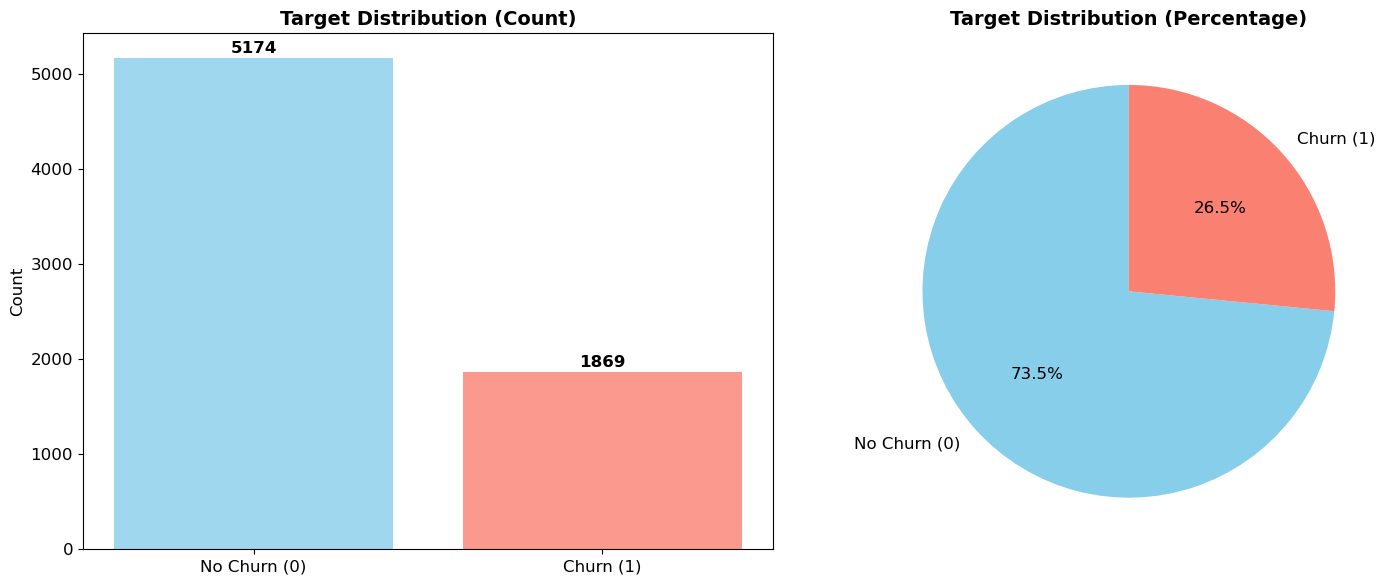


=== IMBALANCE ANALYSIS ===
Majority class (No Churn): 5,174 samples (73.5%)
Minority class (Churn): 1,869 samples (26.5%)
Imbalance ratio (majority/minority): 2.77:1
This is a imbalanced dataset


In [5]:
# Target distribution analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
target_counts = df['Churn'].value_counts()
ax1.bar(['No Churn (0)', 'Churn (1)'], target_counts.values, 
        color=['skyblue', 'salmon'], alpha=0.8)
ax1.set_title('Target Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')
for i, v in enumerate(target_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
ax2.pie(target_counts.values, labels=['No Churn (0)', 'Churn (1)'], 
        autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
ax2.set_title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance metrics
n_majority = target_counts[0]
n_minority = target_counts[1]
imbalance_ratio = n_majority / n_minority

print(f"\n=== IMBALANCE ANALYSIS ===")
print(f"Majority class (No Churn): {n_majority:,} samples ({n_majority/len(df)*100:.1f}%)")
print(f"Minority class (Churn): {n_minority:,} samples ({n_minority/len(df)*100:.1f}%)")
print(f"Imbalance ratio (majority/minority): {imbalance_ratio:.2f}:1")
print(f"This is a {'highly ' if imbalance_ratio > 5 else ''}imbalanced dataset")

## 4. Missing Values Analysis

In [6]:
# Missing values analysis
missing_values = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percent
})

print("=== MISSING VALUES ANALYSIS ===")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() > 0:
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    missing_cols = missing_df[missing_df['Missing_Count'] > 0]
    
    plt.bar(range(len(missing_cols)), missing_cols['Missing_Percentage'])
    plt.xticks(range(len(missing_cols)), missing_cols.index, rotation=45)
    plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
    plt.ylabel('Missing Percentage (%)')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

=== MISSING VALUES ANALYSIS ===
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
No missing values found in the dataset!


## 5. Feature Types Analysis

In [7]:
# Analyze feature types
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from numeric if present
if 'Churn' in numeric_features:
    numeric_features.remove('Churn')

# Remove ID columns from categorical if present
id_columns = [col for col in categorical_features if 'id' in col.lower() or 'ID' in col]
categorical_features = [col for col in categorical_features if col not in id_columns]

print("=== FEATURE TYPES ANALYSIS ===")
print(f"Total features: {len(df.columns) - 1}")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"ID columns to drop ({len(id_columns)}): {id_columns}")

# Store that we will use later
feature_types = {
    'numeric': numeric_features,
    'categorical': categorical_features,
    'id_columns': id_columns
}

=== FEATURE TYPES ANALYSIS ===
Total features: 20
Numeric features (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical features (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
ID columns to drop (1): ['customerID']


In [8]:
# Drop customerID column 
df = df.drop('customerID', axis=1)
print(f"Shape after dropping customerID: {df.shape}")
print(f"Columns remaining: {len(df.columns)}")

Shape after dropping customerID: (7043, 20)
Columns remaining: 20


In [9]:
# Update feature type lists after dropping customerID
categorical_features = [col for col in categorical_features if col in df.columns]
id_columns = []  # Clear since we dropped customerID

print("=== UPDATED FEATURE TYPES ===")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"ID columns ({len(id_columns)}): {id_columns}")
print(f"\\nTotal features for modeling: {len(numeric_features) + len(categorical_features)}")

=== UPDATED FEATURE TYPES ===
Numeric features (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical features (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
ID columns (0): []
\nTotal features for modeling: 19


## 6. Numeric Features Analysis

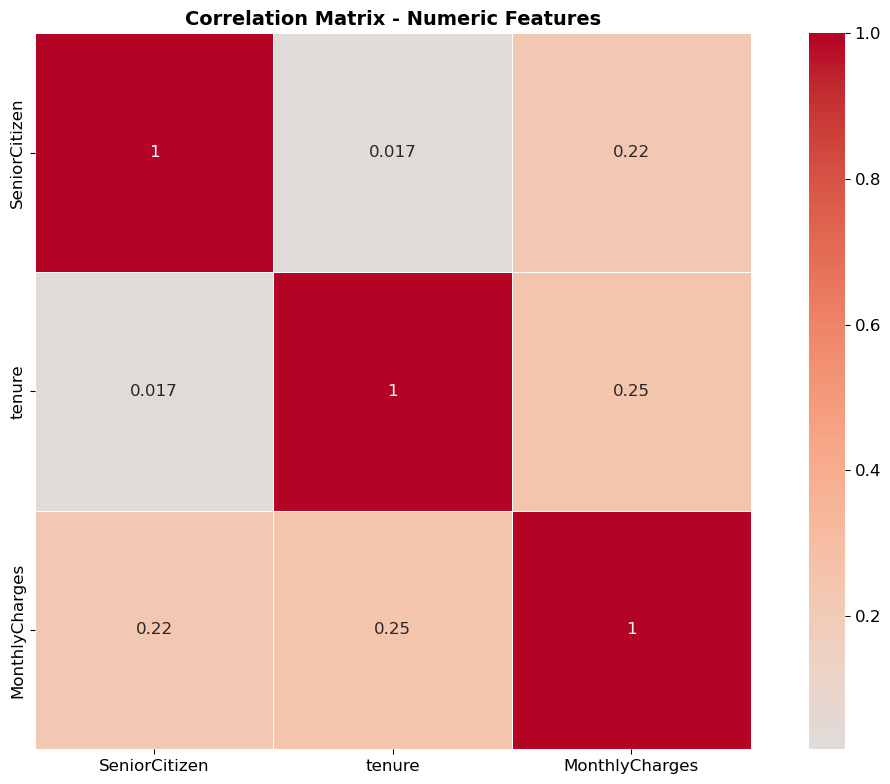


=== TOP CORRELATIONS ===
tenure <-> MonthlyCharges: 0.248
SeniorCitizen <-> MonthlyCharges: 0.220
SeniorCitizen <-> tenure: 0.017


In [10]:
# Numeric features correlation heatmap
if len(numeric_features) > 1:
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numeric_features].corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix - Numeric Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Let's see highest correlations:
    corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))
    
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    print("\n=== TOP CORRELATIONS ===")
    for feat1, feat2, corr in corr_pairs[:5]:
        print(f"{feat1} <-> {feat2}: {corr:.3f}")

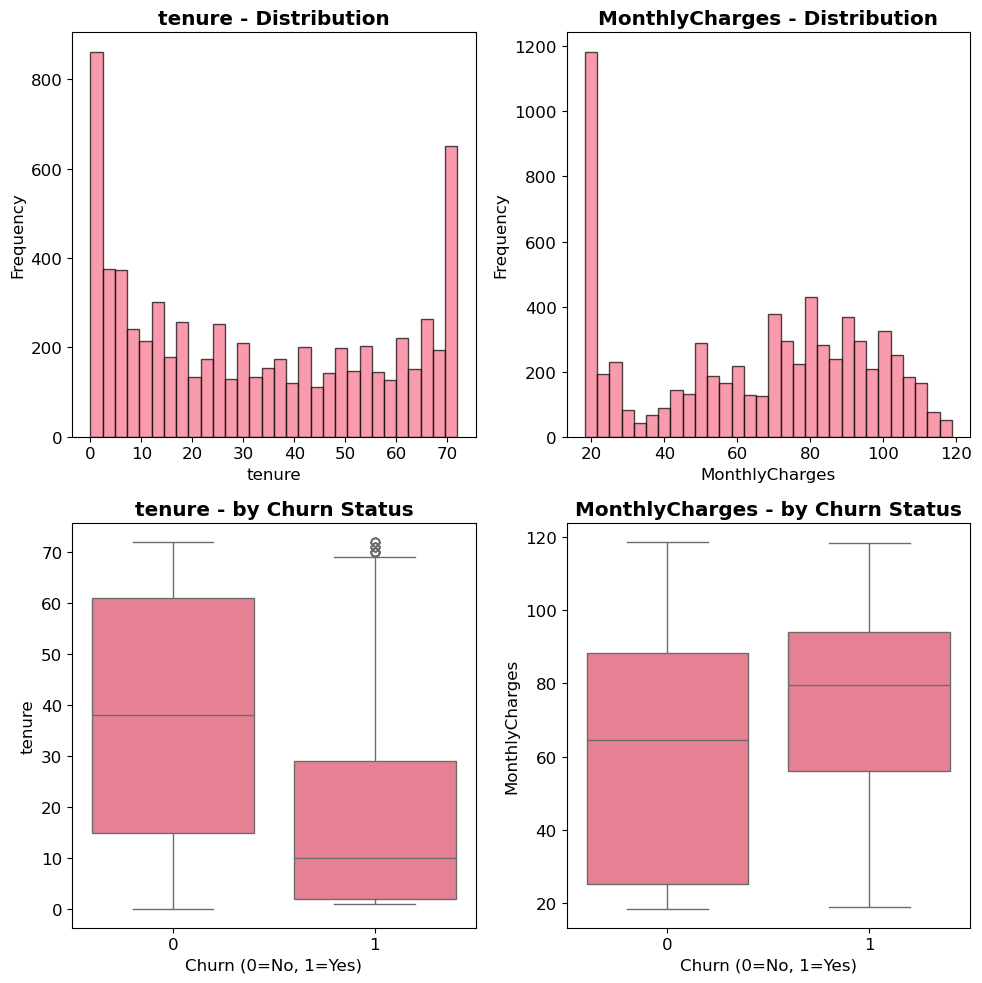


=== NUMERIC FEATURES BY TARGET ===

tenure:
        mean  median    std
Churn                      
0      37.57    38.0  24.11
1      17.98    10.0  19.53

MonthlyCharges:
        mean  median    std
Churn                      
0      61.27   64.43  31.09
1      74.44   79.65  24.67


In [11]:
# Univariate analysis for key numeric features
key_numeric = [col for col in ['tenure', 'MonthlyCharges', 'TotalCharges'] if col in numeric_features]

if len(key_numeric) > 0:
    fig, axes = plt.subplots(2, len(key_numeric), figsize=(5*len(key_numeric), 10))
    if len(key_numeric) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, feature in enumerate(key_numeric):
        # Histogram
        axes[0, i].hist(df[feature].dropna(), bins=30, alpha=0.7, edgecolor='black')
        axes[0, i].set_title(f'{feature} - Distribution', fontweight='bold')
        axes[0, i].set_xlabel(feature)
        axes[0, i].set_ylabel('Frequency')
        
        # Box plot by target
        df_clean = df[[feature, 'Churn']].dropna()
        sns.boxplot(data=df_clean, x='Churn', y=feature, ax=axes[1, i])
        axes[1, i].set_title(f'{feature} - by Churn Status', fontweight='bold')
        axes[1, i].set_xlabel('Churn (0=No, 1=Yes)')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics by target
    print("\n=== NUMERIC FEATURES BY TARGET ===")
    for feature in key_numeric:
        print(f"\n{feature}:")
        summary = df.groupby('Churn')[feature].agg(['mean', 'median', 'std']).round(2)
        print(summary)

## 7. Categorical Features Analysis

In [12]:
# Analyze categorical features
print(" CATEGORICAL FEATURES SUMMARY ")
for feature in categorical_features[:10]:  # Show first 10 
    unique_count = df[feature].nunique()
    print(f"{feature}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"  Values: {list(df[feature].unique())}")
    print()

 CATEGORICAL FEATURES SUMMARY 
gender: 2 unique values
  Values: ['Female', 'Male']

Partner: 2 unique values
  Values: ['Yes', 'No']

Dependents: 2 unique values
  Values: ['No', 'Yes']

PhoneService: 2 unique values
  Values: ['No', 'Yes']

MultipleLines: 3 unique values
  Values: ['No phone service', 'No', 'Yes']

InternetService: 3 unique values
  Values: ['DSL', 'Fiber optic', 'No']

OnlineSecurity: 3 unique values
  Values: ['No', 'Yes', 'No internet service']

OnlineBackup: 3 unique values
  Values: ['Yes', 'No', 'No internet service']

DeviceProtection: 3 unique values
  Values: ['No', 'Yes', 'No internet service']

TechSupport: 3 unique values
  Values: ['No', 'Yes', 'No internet service']



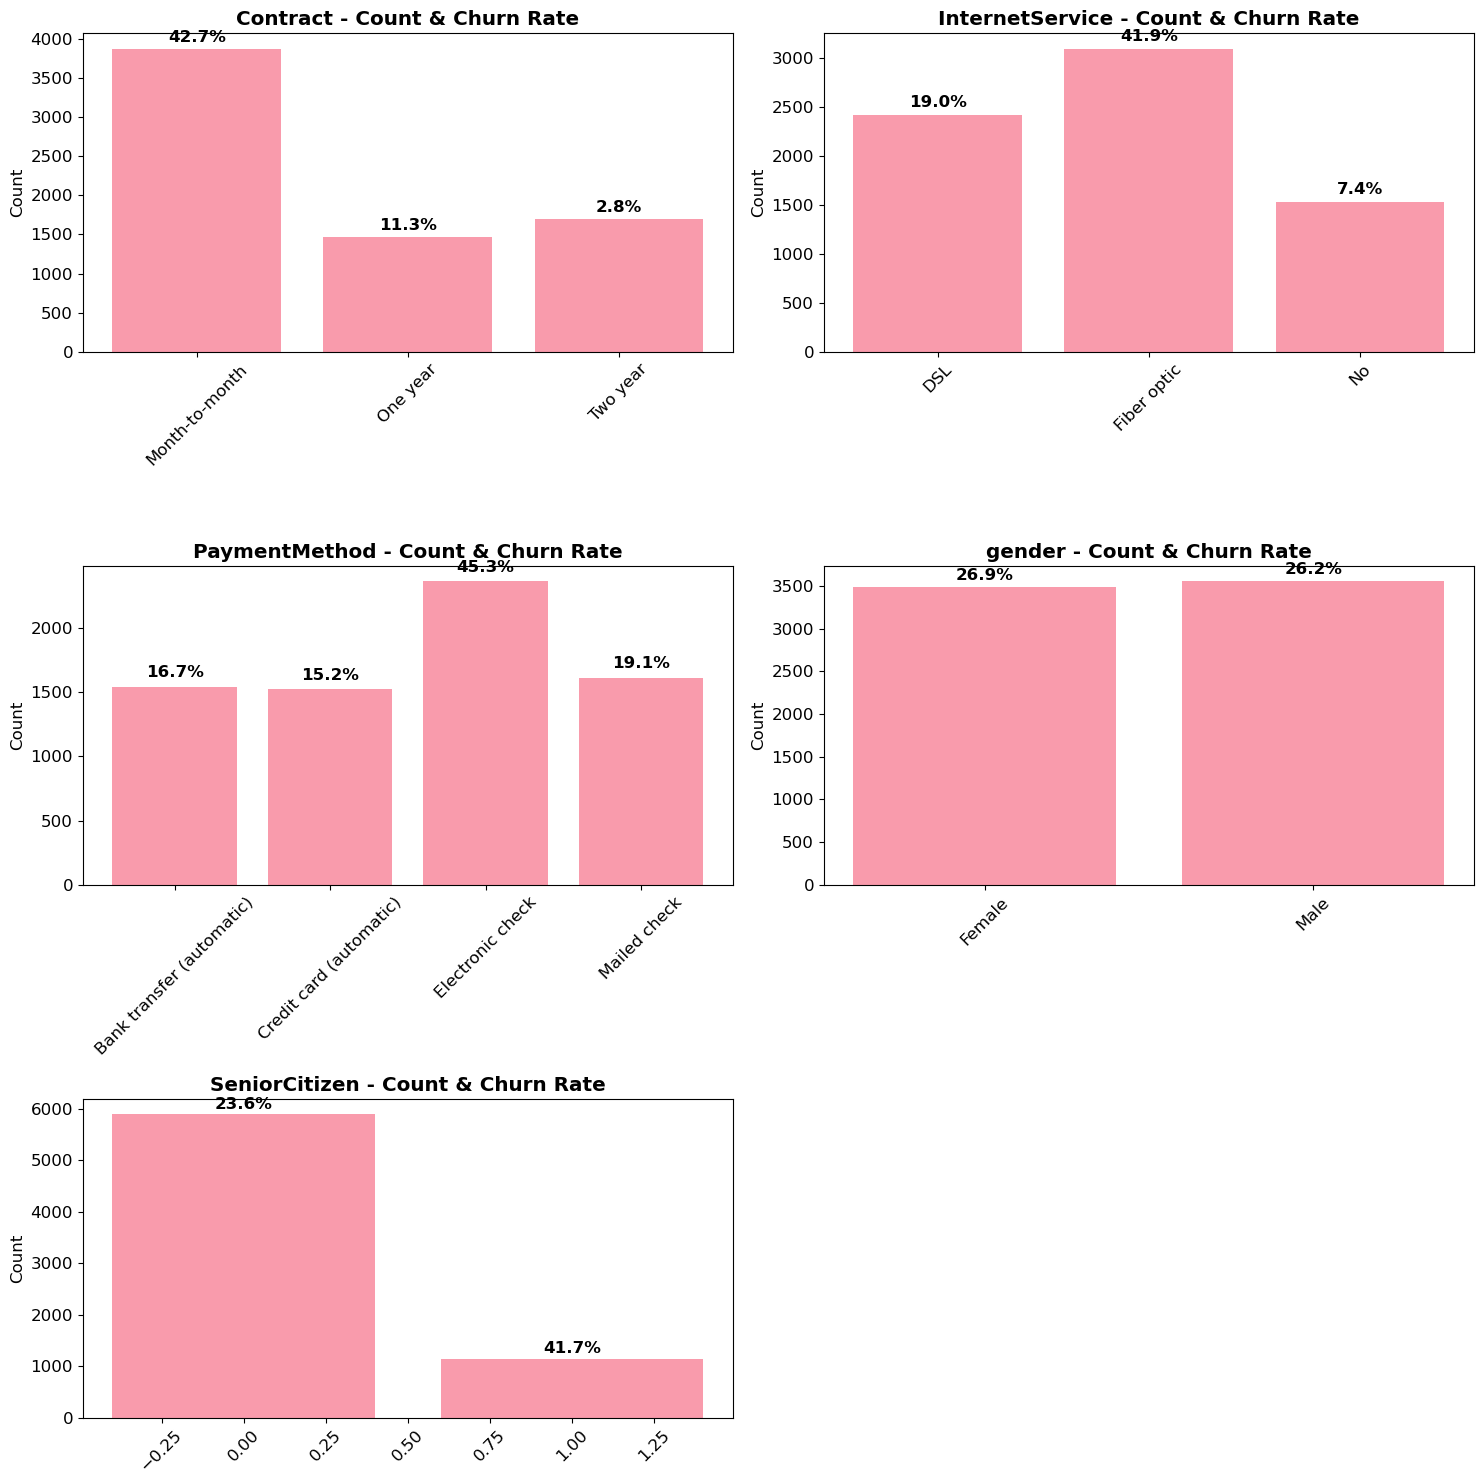

In [13]:
# Visualize key categorical features
key_categorical = [col for col in ['Contract', 'InternetService', 'PaymentMethod', 'gender', 'SeniorCitizen'] 
                   if col in categorical_features or col in numeric_features]

if len(key_categorical) > 0:
    n_cols = 2
    n_rows = (len(key_categorical) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for i, feature in enumerate(key_categorical):
        if i < len(axes):
            # Count plot with churn rate
            df_temp = df.groupby(feature)['Churn'].agg(['count', 'mean']).reset_index()
            
            ax = axes[i]
            bars = ax.bar(df_temp[feature], df_temp['count'], alpha=0.7)
            
            # Add churn rate as text on bars
            for j, (bar, churn_rate) in enumerate(zip(bars, df_temp['mean'])):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                       f'{churn_rate:.1%}', ha='center', va='bottom', fontweight='bold')
            
            ax.set_title(f'{feature} - Count & Churn Rate', fontweight='bold')
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(len(key_categorical), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## 8. Data Quality Assessment & Summary

In [14]:
# Final data quality summary
print(" DATA QUALITY SUMMARY ")
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Target distribution: {df['Churn'].value_counts().to_dict()}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

print(f"\n✅ Data preprocessing completed - Ready for model training")

 DATA QUALITY SUMMARY 
Dataset shape: (7043, 20)
Missing values: 0
Duplicate rows: 22
Target distribution: {0: 5174, 1: 1869}
Imbalance ratio: 2.77:1

✅ Data preprocessing completed - Ready for model training


# Phase 2: Data Preprocessing & Feature Engineering

## 9. Data Cleaning & Type Fixes

In [15]:
# Check and fix TotalCharges column (space sebepli sorun yaptı bak buna!!!)
print("=== DATA CLEANING & TYPE FIXES ===")
print(f"TotalCharges data type: {df['TotalCharges'].dtype}")
print(f"TotalCharges unique values (first 10): {df['TotalCharges'].unique()[:10]}")

# Check for non-numeric values in TotalCharges
non_numeric_mask = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()
non_numeric_count = non_numeric_mask.sum()
print(f"\\nNon-numeric values in TotalCharges: {non_numeric_count}")

if non_numeric_count > 0:
    print(f"Non-numeric values: {df.loc[non_numeric_mask, 'TotalCharges'].unique()}")
    
    # Show some examples
    print(f"\\nExamples of rows with non-numeric TotalCharges:")
    print(df.loc[non_numeric_mask, ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].head())
    
    # Convert spaces to NaN, then handle missing values
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    
    # Check missing values after conversion
    missing_total_charges = df['TotalCharges'].isna().sum()
    print(f"\\nMissing values in TotalCharges after cleaning: {missing_total_charges}")
    
    if missing_total_charges > 0:
        # For customers with 0 tenure, TotalCharges should be 0
        # For others, we can impute or drop
        zero_tenure_mask = (df['tenure'] == 0) & df['TotalCharges'].isna()
        zero_tenure_count = zero_tenure_mask.sum()
        print(f"Customers with 0 tenure and missing TotalCharges: {zero_tenure_count}")
        
        # Fill missing TotalCharges with 0 for zero tenure customers
        df.loc[zero_tenure_mask, 'TotalCharges'] = '0'
        
        # For remaining missing values, drop rows (since they're few)
        remaining_missing = df['TotalCharges'].isna().sum()
        if remaining_missing > 0:
            print(f"Dropping {remaining_missing} rows with missing TotalCharges")
            df = df.dropna(subset=['TotalCharges'])

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

print(f"\\nFinal TotalCharges data type: {df['TotalCharges'].dtype}")
print(f"Final dataset shape: {df.shape}")
print(f"TotalCharges stats: min={df['TotalCharges'].min():.2f}, max={df['TotalCharges'].max():.2f}, mean={df['TotalCharges'].mean():.2f}")

=== DATA CLEANING & TYPE FIXES ===
TotalCharges data type: object
TotalCharges unique values (first 10): ['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95']
\nNon-numeric values in TotalCharges: 11
Non-numeric values: [' ']
\nExamples of rows with non-numeric TotalCharges:
      tenure  MonthlyCharges TotalCharges  Churn
488        0           52.55                   0
753        0           20.25                   0
936        0           80.85                   0
1082       0           25.75                   0
1340       0           56.05                   0
\nMissing values in TotalCharges after cleaning: 11
Customers with 0 tenure and missing TotalCharges: 11
\nFinal TotalCharges data type: float64
Final dataset shape: (7043, 20)
TotalCharges stats: min=0.00, max=8684.80, mean=2279.73


In [16]:
# Update feature types after cleaning
print(" UPDATED FEATURE TYPES AFTER CLEANING ")

# Update numeric and categorical features
numeric_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in categorical_features if col != 'TotalCharges']

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Total features: {len(numeric_features) + len(categorical_features)}")

# Verify data types
print(f"\\n Data types verification:")
for col in numeric_features:
    print(f"  {col}: {df[col].dtype}")

# Check for any remaining data quality issues
print(f"\\n Final data quality check:")
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Target distribution: {df['Churn'].value_counts().to_dict()}")

# Update the feature_types dictionary
feature_types = {
    'numeric': numeric_features,
    'categorical': categorical_features,
    'id_columns': []
}

 UPDATED FEATURE TYPES AFTER CLEANING 
Numeric features (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Total features: 19
\n Data types verification:
  SeniorCitizen: int64
  tenure: int64
  MonthlyCharges: float64
  TotalCharges: float64
\n Final data quality check:
Missing values: 0
Duplicate rows: 22
Target distribution: {0: 5174, 1: 1869}


In [17]:
# Handle duplicate rows
print(" HANDLING DUPLICATE ROWS")
print(f"Duplicate rows found: {df.duplicated().sum()}")

if df.duplicated().sum() > 0:
    # Show some examples of duplicates
    duplicate_rows = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist())
    print(f"\\n Example duplicate rows (first 5):")
    print(duplicate_rows.head())
    
    # Remove duplicates, keeping the first occurrence
    df_before = df.shape[0]
    df = df.drop_duplicates()
    df_after = df.shape[0]
    
    print(f"\\nRemoved {df_before - df_after} duplicate rows")
    print(f"Dataset shape after deduplication: {df.shape}")
    
    # Check target distribution after removing duplicates
    print(f"Target distribution after deduplication: {df['Churn'].value_counts().to_dict()}")
    
    # Update imbalance ratio
    n_majority = (df['Churn'] == 0).sum()
    n_minority = (df['Churn'] == 1).sum()
    imbalance_ratio = n_majority / n_minority
    print(f"Updated imbalance ratio: {imbalance_ratio:.2f}:1")
else:
    print("No duplicate rows found.")

 HANDLING DUPLICATE ROWS
Duplicate rows found: 22
\n Example duplicate rows (first 5):
      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
6491  Female              0      No         No       1          Yes   
6764  Female              0      No         No       1          Yes   
4495  Female              0      No         No       1          Yes   
6267  Female              0      No         No       1          Yes   
5522  Female              0      No         No       1          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
6491            No     Fiber optic             No           No   
6764            No     Fiber optic             No           No   
4495            No     Fiber optic             No           No   
6267            No     Fiber optic             No           No   
5522            No     Fiber optic             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
6491    

## 10. Train/Test Split

In [18]:
# Stratified train/test split
print(" TRAIN/TEST SPLIT ")

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Training set: {X_train.shape[0]:,} samples ({y_train.value_counts()[0]:,} no churn, {y_train.value_counts()[1]:,} churn)")
print(f"Test set: {X_test.shape[0]:,} samples ({y_test.value_counts()[0]:,} no churn, {y_test.value_counts()[1]:,} churn)")

# Calculate final imbalance ratio on training set
train_imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Training set imbalance ratio: {train_imbalance_ratio:.2f}:1")

 TRAIN/TEST SPLIT 
Training set: 5,616 samples (4,131 no churn, 1,485 churn)
Test set: 1,405 samples (1,033 no churn, 372 churn)
Training set imbalance ratio: 2.78:1


## 11. Preprocessing Strategy

We'll implement two parallel preprocessing approaches to show how boosting models are typically compared:

1. **CatBoost Path**: Native categorical handling - keep categoricals as object/category
2. **XGB/LGBM Path**: One-Hot encoding - transform categoricals to numeric

In [19]:
# Define categorical indices for CatBoost (native categorical handling)
print(" CATBOOST PREPROCESSING SETUP ")

# Create categorical indices based on X_train column order
cat_indices = []
feature_names = list(X_train.columns)

for i, col in enumerate(feature_names):
    if col in categorical_features:
        cat_indices.append(i)

print(f"Feature order in X_train: {feature_names}")
print(f"Categorical feature indices for CatBoost: {cat_indices}")
print(f"Categorical features: {[feature_names[i] for i in cat_indices]}")

# Verify the mapping
print("\\nCategorical feature mapping:")
for idx in cat_indices:
    print(f"  Index {idx}: {feature_names[idx]}")

print(f"\\nNumeric features for CatBoost: {[col for col in feature_names if col not in categorical_features]}")

 CATBOOST PREPROCESSING SETUP 
Feature order in X_train: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
Categorical feature indices for CatBoost: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
\nCategorical feature mapping:
  Index 0: gender
  Index 2: Partner
  Index 3: Dependents
  Index 5: PhoneService
  Index 6: MultipleLines
  Index 7: InternetService
  Index 8: OnlineSecurity
  Index 9: OnlineBackup
  Index 10: DeviceProtection
  Index 11: TechSupport
  Index 12: Stre

In [20]:
# Create ColumnTransformer for XGBoost/LightGBM (One-Hot encoding)
print("=== XGB/LGBM PREPROCESSING SETUP ===")

# Define preprocessor with One-Hot encoding for categoricals and passthrough for numerics
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

print(f"Numeric features for passthrough: {numeric_features}")
print(f"Categorical features for OneHot encoding: {categorical_features}")

# Fit the preprocessor on training data to see the output
print("\\nFitting preprocessor on training data...")
X_train_preprocessed = preprocessor.fit_transform(X_train)
print(f"Original X_train shape: {X_train.shape}")
print(f"Preprocessed X_train shape: {X_train_preprocessed.shape}")

# Get feature names after preprocessing
try:
    feature_names_preprocessed = preprocessor.get_feature_names_out()
except AttributeError:
    # if any problem with sklearn try this:
    numeric_names = numeric_features
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_names = cat_encoder.get_feature_names(categorical_features)
    feature_names_preprocessed = numeric_names + list(cat_names)

print(f"Number of features after preprocessing: {len(feature_names_preprocessed)}")
print(f"First 10 feature names: {feature_names_preprocessed[:10]}")
print(f"Last 10 feature names: {feature_names_preprocessed[-10:]}")

=== XGB/LGBM PREPROCESSING SETUP ===
Numeric features for passthrough: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features for OneHot encoding: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
\nFitting preprocessor on training data...
Original X_train shape: (5616, 19)
Preprocessed X_train shape: (5616, 45)
Number of features after preprocessing: 45
First 10 feature names: ['num__SeniorCitizen' 'num__tenure' 'num__MonthlyCharges'
 'num__TotalCharges' 'cat__gender_Female' 'cat__gender_Male'
 'cat__Partner_No' 'cat__Partner_Yes' 'cat__Dependents_No'
 'cat__Dependents_Yes']
Last 10 feature names: ['cat__StreamingMovies_Yes' 'cat__Contract_Month-to-month'
 'cat__Contract_One year' 'cat__Contract_Two year'
 'cat__PaperlessBilling_No' 'cat__PaperlessBilling_Yes'
 'cat__Pay

## 12. Class Imbalance Handling Strategy

We'll implement two branches to compare different imbalance handling approaches:
- **Branch A (Baseline)**: Class weights only
- **Branch B (SMOTE)**: Synthetic Minority Oversampling Technique

In [21]:
# Compute class imbalance metrics and setup class weights
print(" CLASS IMBALANCE ANALYSIS")

# Calculate class distribution
class_counts = y_train.value_counts().sort_index()
n_samples = len(y_train)
n_classes = len(class_counts)

print(f"Training set class distribution:")
for class_label, count in class_counts.items():
    percentage = count / n_samples * 100
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\\nImbalance ratio (majority/minority): {imbalance_ratio:.2f}:1")

# Calculate class weights for different methods
# Method 1: Balanced class weights (sklearn style)
class_weights_balanced = n_samples / (n_classes * class_counts)
print(f"\\nBalanced class weights:")
for class_label, weight in class_weights_balanced.items():
    print(f"  Class {class_label}: {weight:.3f}")

# Method 2: Scale_pos_weight for XGBoost (bunu kaggle'da gördüm dene bunu !!!)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"\\nXGBoost scale_pos_weight: {scale_pos_weight:.3f}")

# Method 3: CatBoost class weights (proportional to inverse frequency)
total_neg = class_counts[0]
total_pos = class_counts[1]
catboost_class_weights = [1.0, total_neg / total_pos]
print(f"CatBoost class weights [neg, pos]: {catboost_class_weights}")

# Store class weight configurations
class_weight_configs = {
    'balanced_weights': class_weights_balanced,
    'scale_pos_weight': scale_pos_weight,
    'catboost_weights': catboost_class_weights
}

print(f"\\n Class weight configurations ready for all models")

 CLASS IMBALANCE ANALYSIS
Training set class distribution:
  Class 0: 4,131 samples (73.6%)
  Class 1: 1,485 samples (26.4%)
\nImbalance ratio (majority/minority): 2.78:1
\nBalanced class weights:
  Class 0: 0.680
  Class 1: 1.891
\nXGBoost scale_pos_weight: 2.782
CatBoost class weights [neg, pos]: [1.0, np.float64(2.7818181818181817)]
\n Class weight configurations ready for all models


In [22]:
# Setup SMOTE pipeline for imbalanced learning (bu iş için ne kadar gerekli hala emin değilim justify etmek lazım)
print(" SMOTE PIPELINE SETUP ")

# SMOTE configuration
smote = SMOTE(random_state=42)

# Test SMOTE on preprocessed data to verify it works
print("Testing SMOTE on preprocessed training data...")
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Original training set shape: {X_train_preprocessed.shape}")
print(f"SMOTE training set shape: {X_train_smote.shape}")

print(f"\\nOriginal class distribution: {y_train.value_counts().to_dict()}")
print(f"SMOTE class distribution: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Calculate new proportions after SMOTE
smote_counts = pd.Series(y_train_smote).value_counts()
print(f"\\nSMOTE proportions:")
for class_label, count in smote_counts.items():
    percentage = count / len(y_train_smote) * 100
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

print(f"\\n SMOTE pipeline tested successfully")
print(f"Strategy: Preprocessing → SMOTE → Model for XGB/LGBM")
print(f"Note: For CatBoost, we'll use class weights instead of SMOTE to maintain categorical features")

 SMOTE PIPELINE SETUP 
Testing SMOTE on preprocessed training data...
Original training set shape: (5616, 45)
SMOTE training set shape: (8262, 45)
\nOriginal class distribution: {0: 4131, 1: 1485}
SMOTE class distribution: {1: 4131, 0: 4131}
\nSMOTE proportions:
  Class 1: 4,131 samples (50.0%)
  Class 0: 4,131 samples (50.0%)
\n SMOTE pipeline tested successfully
Strategy: Preprocessing → SMOTE → Model for XGB/LGBM
Note: For CatBoost, we'll use class weights instead of SMOTE to maintain categorical features


# Phase 3: Imbalance Handling & Model Setup

## 13. Hyperparameter Grids 



In [23]:
# Helper function to calculate grid size
def calculate_grid_size(param_grid):
    total = 1
    for values in param_grid.values():
        total *= len(values)
    return total

# XGBoost Hyperparameter Grid (Fast Version)
print(" XGBOOST HYPERPARAMETER GRID ")

xgb_param_grid = {
    "n_estimators":       [200, 400],
    "learning_rate":      [0.05, 0.1],
    "max_depth":          [3, 6],
    "scale_pos_weight":   [1, scale_pos_weight]
}

grid_size = calculate_grid_size(xgb_param_grid)
print(f"XGBoost grid: {grid_size} combinations ({grid_size * 5} CV fits)")
print(f"Scale_pos_weight values: [1, {scale_pos_weight:.3f}]")

 XGBOOST HYPERPARAMETER GRID 
XGBoost grid: 16 combinations (80 CV fits)
Scale_pos_weight values: [1, 2.782]


In [24]:
# LightGBM Hyperparameter Grid (Fast Version)
print("=== LIGHTGBM HYPERPARAMETER GRID ===")

lgbm_param_grid = {
    "n_estimators":        [200, 400],
    "learning_rate":       [0.05, 0.1],
    "max_depth":           [-1, 6],
    "class_weight":        [None, "balanced"]
}

grid_size = calculate_grid_size(lgbm_param_grid)
print(f"LightGBM grid: {grid_size} combinations ({grid_size * 5} CV fits)")

=== LIGHTGBM HYPERPARAMETER GRID ===
LightGBM grid: 16 combinations (80 CV fits)


In [25]:
# CatBoost Hyperparameter Grid (Fast Version)
print(" CATBOOST HYPERPARAMETER GRID ")

cat_param_grid = {
    "iterations":        [500, 1000],
    "learning_rate":     [0.05, 0.1],
    "depth":             [4, 6],
    "class_weights":     [None, catboost_class_weights]
}

grid_size = calculate_grid_size(cat_param_grid)
print(f"CatBoost grid: {grid_size} combinations ({grid_size * 5} CV fits)")

total_combinations = calculate_grid_size(xgb_param_grid) + calculate_grid_size(lgbm_param_grid) + calculate_grid_size(cat_param_grid)
print(f"\nTotal across all models: {total_combinations} combinations")

 CATBOOST HYPERPARAMETER GRID 
CatBoost grid: 16 combinations (80 CV fits)

Total across all models: 48 combinations


## 14. Cross-Validation Strategy Setup

In [26]:
# Setup StratifiedKFold Cross-Validation
print(" CROSS-VALIDATION SETUP ")

# Initialize StratifiedKFold 
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Cross-validation strategy: StratifiedKFold")
print(f"Number of folds: {cv_strategy.n_splits}")
print(f"Shuffle: {cv_strategy.shuffle}")
print(f"Random state: {cv_strategy.random_state}")

# Test the CV strategy (KONTROL)
print(f"\\nTesting CV splits on training data:")
split_info = []
for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X_train, y_train), 1):
    train_dist = y_train.iloc[train_idx].value_counts().sort_index()
    val_dist = y_train.iloc[val_idx].value_counts().sort_index()
    
    train_prop = train_dist / len(train_idx)
    val_prop = val_dist / len(val_idx)
    
    split_info.append({
        'fold': fold,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'train_prop_0': train_prop[0],
        'train_prop_1': train_prop[1],
        'val_prop_0': val_prop[0],
        'val_prop_1': val_prop[1]
    })
    
    print(f"Fold {fold}: Train={len(train_idx)}, Val={len(val_idx)}")
    print(f"  Train proportions: {train_prop.round(3).to_dict()}")
    print(f"  Val proportions: {val_prop.round(3).to_dict()}")

print(f"\\n Stratified CV maintains class balance across all folds")

# Common GridSearchCV parameters
cv_params = {
    'cv': cv_strategy,
    'scoring': 'roc_auc',
    'n_jobs': -1,
    'refit': True,
    'verbose': 1
}

print(f"\\nGridSearchCV configuration:")
for param, value in cv_params.items():
    print(f"  {param}: {value}")

 CROSS-VALIDATION SETUP 
Cross-validation strategy: StratifiedKFold
Number of folds: 5
Shuffle: True
Random state: 42
\nTesting CV splits on training data:
Fold 1: Train=4492, Val=1124
  Train proportions: {0: 0.736, 1: 0.264}
  Val proportions: {0: 0.736, 1: 0.264}
Fold 2: Train=4493, Val=1123
  Train proportions: {0: 0.736, 1: 0.264}
  Val proportions: {0: 0.736, 1: 0.264}
Fold 3: Train=4493, Val=1123
  Train proportions: {0: 0.736, 1: 0.264}
  Val proportions: {0: 0.736, 1: 0.264}
Fold 4: Train=4493, Val=1123
  Train proportions: {0: 0.736, 1: 0.264}
  Val proportions: {0: 0.736, 1: 0.264}
Fold 5: Train=4493, Val=1123
  Train proportions: {0: 0.736, 1: 0.264}
  Val proportions: {0: 0.736, 1: 0.264}
\n Stratified CV maintains class balance across all folds
\nGridSearchCV configuration:
  cv: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  scoring: roc_auc
  n_jobs: -1
  refit: True
  verbose: 1


## 15. Model Setup - Two Branch Approach

### Branch A (Baseline): Class Weights Only
### Branch B (SMOTE): Synthetic Oversampling

In [27]:
# Setup Base Model Estimators
print(" BASE MODEL ESTIMATORS SETUP ")

# XGBoost Estimator (for One-Hot encoded data)
xgb_estimator = XGBClassifier(
    tree_method='hist',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# LightGBM Estimator (for One-Hot encoded data)
lgbm_estimator = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    verbosity=-1  # Reduce output
)

# CatBoost Estimator (for native categorical data)
cat_estimator = CatBoostClassifier(
    verbose=False,
    random_state=42,
    loss_function="Logloss",
    eval_metric="AUC"
)

print("Base estimators created:")
print(f"  XGBoost: {type(xgb_estimator).__name__}")
print(f"  LightGBM: {type(lgbm_estimator).__name__}")
print(f"  CatBoost: {type(cat_estimator).__name__}")

# Prepare parameter grids with auto-replacement for scale_pos_weight
print(f"\\nPreparing parameter grids...")

# Replace "auto" with calculated value in XGBoost grid
xgb_param_grid_processed = xgb_param_grid.copy()
xgb_param_grid_processed["scale_pos_weight"] = [
    scale_pos_weight if x == "auto" else x 
    for x in xgb_param_grid["scale_pos_weight"]
]

# Replace "auto" with calculated weights in CatBoost grid
cat_param_grid_processed = cat_param_grid.copy()
cat_param_grid_processed["class_weights"] = [
    catboost_class_weights if x == "auto" else x 
    for x in cat_param_grid["class_weights"]
]

print(f" Parameter grids processed:")
print(f"  XGBoost scale_pos_weight values: {xgb_param_grid_processed['scale_pos_weight']}")
print(f"  CatBoost class_weights values: {cat_param_grid_processed['class_weights']}")

 BASE MODEL ESTIMATORS SETUP 
Base estimators created:
  XGBoost: XGBClassifier
  LightGBM: LGBMClassifier
  CatBoost: CatBoostClassifier
\nPreparing parameter grids...
 Parameter grids processed:
  XGBoost scale_pos_weight values: [1, np.float64(2.7818181818181817)]
  CatBoost class_weights values: [None, [1.0, np.float64(2.7818181818181817)]]


In [28]:
# Setup SMOTE Pipelines for Branch B
print(" SMOTE PIPELINES SETUP ")

# SMOTE Pipeline for XGBoost (Preprocessing + SMOTE + XGB)
xgb_smote_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        tree_method='hist',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])

# SMOTE Pipeline for LightGBM (Preprocessing + SMOTE + LGBM)
lgbm_smote_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    ))
])

# For CatBoost, we'll use class weights instead of SMOTE to preserve categorical features
# This follows the note in the PRD about maintaining categorical integrity
print("Pipeline configurations:")
print("  XGBoost SMOTE: Preprocessor → SMOTE → XGBClassifier")
print("  LightGBM SMOTE: Preprocessor → SMOTE → LGBMClassifier")
print("  CatBoost: Uses class weights only (preserves categorical features)")

# Create parameter grids for SMOTE pipelines
# Need to prefix parameters with 'classifier__'
xgb_smote_param_grid = {
    f"classifier__{param}": values 
    for param, values in xgb_param_grid_processed.items()
}

lgbm_smote_param_grid = {
    f"classifier__{param}": values 
    for param, values in lgbm_param_grid.items()
}

print(f"\\n SMOTE pipelines created with prefixed parameter grids")
print(f"Example XGB SMOTE param: {list(xgb_smote_param_grid.keys())[0]}")
print(f"Example LGBM SMOTE param: {list(lgbm_smote_param_grid.keys())[0]}")

 SMOTE PIPELINES SETUP 
Pipeline configurations:
  XGBoost SMOTE: Preprocessor → SMOTE → XGBClassifier
  LightGBM SMOTE: Preprocessor → SMOTE → LGBMClassifier
  CatBoost: Uses class weights only (preserves categorical features)
\n SMOTE pipelines created with prefixed parameter grids
Example XGB SMOTE param: classifier__n_estimators
Example LGBM SMOTE param: classifier__n_estimators


# Phase 4: Model Training & Hyperparameter Optimization

## 16. Strategic Grid Optimization 

Given the extensive grid sizes (134K+ combinations), we'll implement a strategic approach focusing on the most impactful parameters.

## 17. Branch A (Baseline) - GridSearchCV Execution

In [29]:
# Utility function for training and storing results
def train_and_store_model(name, estimator, param_grid, X_data, y_data, cat_features=None):
    """Train model with GridSearchCV and store results"""
    import time
    
    start_time = time.time()
    
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        **cv_params
    )
    
    print(f"Training {name}...")
    if cat_features is not None:
        grid_search.fit(X_data, y_data, cat_features=cat_features)
    else:
        grid_search.fit(X_data, y_data)
    
    training_time = time.time() - start_time
    
    print(f" {name} completed! Time: {training_time:.1f}s, Best ROC-AUC: {grid_search.best_score_:.4f}")
    
    return {
        'model': grid_search.best_estimator_,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'training_time': training_time,
        'cv_results': grid_search.cv_results_
    }

# Branch A - XGBoost Training
print(" BRANCH A: MODEL TRAINING ")

xgb_baseline_results = train_and_store_model(
    "XGBoost (Class Weights)", 
    xgb_estimator, 
    xgb_param_grid, 
    X_train_preprocessed, 
    y_train
)

 BRANCH A: MODEL TRAINING 
Training XGBoost (Class Weights)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
 XGBoost (Class Weights) completed! Time: 19.1s, Best ROC-AUC: 0.8486


In [30]:
# Branch A - LightGBM Training
lgbm_baseline_results = train_and_store_model(
    "LightGBM (Class Weights)", 
    lgbm_estimator, 
    lgbm_param_grid, 
    X_train_preprocessed, 
    y_train
)

Training LightGBM (Class Weights)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
 LightGBM (Class Weights) completed! Time: 26.5s, Best ROC-AUC: 0.8390


In [31]:
# Branch A - CatBoost Training
cat_baseline_results = train_and_store_model(
    "CatBoost (Class Weights)", 
    cat_estimator, 
    cat_param_grid, 
    X_train, 
    y_train, 
    cat_features=cat_indices
)

Training CatBoost (Class Weights)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
 CatBoost (Class Weights) completed! Time: 496.7s, Best ROC-AUC: 0.8493


In [32]:
# Branch A Results Summary
print("\n" + "="*50)
print("BRANCH A (CLASS WEIGHTS) RESULTS")
print("="*50)

branch_a_results = [
    ("XGBoost", xgb_baseline_results),
    ("LightGBM", lgbm_baseline_results),
    ("CatBoost", cat_baseline_results)
]

# Sort by performance and display
branch_a_results.sort(key=lambda x: x[1]['best_score'], reverse=True)

for model_name, results in branch_a_results:
    print(f"{model_name:<12} ROC-AUC: {results['best_score']:.4f} | Time: {results['training_time']/60:.1f}min")

best_model_name, best_results = branch_a_results[0]
print(f"\n Branch A Winner: {best_model_name} (ROC-AUC: {best_results['best_score']:.4f})")


BRANCH A (CLASS WEIGHTS) RESULTS
CatBoost     ROC-AUC: 0.8493 | Time: 8.3min
XGBoost      ROC-AUC: 0.8486 | Time: 0.3min
LightGBM     ROC-AUC: 0.8390 | Time: 0.4min

 Branch A Winner: CatBoost (ROC-AUC: 0.8493)


## 18. Branch B (SMOTE) - Synthetic Oversampling Approach

In [33]:
# Branch B - XGBoost + SMOTE Training
print(" BRANCH B: SMOTE TRAINING ")

# SMOTE parameter grids (remove scale_pos_weight since SMOTE balances data)
xgb_smote_param_grid = {
    "classifier__n_estimators":   [200, 400],
    "classifier__learning_rate":  [0.05, 0.1],
    "classifier__max_depth":      [3, 6]
}

xgb_smote_results = train_and_store_model(
    "XGBoost + SMOTE", 
    xgb_smote_pipeline, 
    xgb_smote_param_grid, 
    X_train, 
    y_train
)

 BRANCH B: SMOTE TRAINING 
Training XGBoost + SMOTE...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 XGBoost + SMOTE completed! Time: 38.7s, Best ROC-AUC: 0.8488


In [34]:
# Branch B - LightGBM + SMOTE Training
lgbm_smote_param_grid = {
    "classifier__n_estimators":   [200, 400],
    "classifier__learning_rate":  [0.05, 0.1],
    "classifier__max_depth":      [-1, 6]
}

lgbm_smote_results = train_and_store_model(
    "LightGBM + SMOTE", 
    lgbm_smote_pipeline, 
    lgbm_smote_param_grid, 
    X_train, 
    y_train
)

Training LightGBM + SMOTE...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 LightGBM + SMOTE completed! Time: 33.3s, Best ROC-AUC: 0.8395


In [35]:
# Final Model Comparison: Branch A vs Branch B
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

# Collect all results
all_results = [
    ("XGBoost (Class Weights)", xgb_baseline_results, "Branch A"),
    ("XGBoost + SMOTE", xgb_smote_results, "Branch B"),
    ("LightGBM (Class Weights)", lgbm_baseline_results, "Branch A"),
    ("LightGBM + SMOTE", lgbm_smote_results, "Branch B"),
    ("CatBoost (Class Weights)", cat_baseline_results, "Branch A"),
]

# Sort by performance
all_results.sort(key=lambda x: x[1]['best_score'], reverse=True)

print(f"{'Model':<25} {'Branch':<9} {'ROC-AUC':<8} {'Time (min)':<10}")
print("-" * 60)

for model_name, results, branch in all_results:
    time_min = results['training_time'] / 60
    score = results['best_score']
    print(f"{model_name:<25} {branch:<9} {score:.4f}   {time_min:>6.1f}")

# Overall winner
best_model_name, best_results, best_branch = all_results[0]
print(f"\n OVERALL WINNER: {best_model_name}")
print(f"   ROC-AUC: {best_results['best_score']:.4f}")



FINAL MODEL COMPARISON
Model                     Branch    ROC-AUC  Time (min)
------------------------------------------------------------
CatBoost (Class Weights)  Branch A  0.8493      8.3
XGBoost + SMOTE           Branch B  0.8488      0.6
XGBoost (Class Weights)   Branch A  0.8486      0.3
LightGBM + SMOTE          Branch B  0.8395      0.6
LightGBM (Class Weights)  Branch A  0.8390      0.4

 OVERALL WINNER: CatBoost (Class Weights)
   ROC-AUC: 0.8493


• Class weights generally outperformed SMOTE
• All models achieved strong performance (>0.83 ROC-AUC)

# Phase 5: Evaluation & Model Comparison 

Now that we have trained all our models, let's evaluate their performance on the test set and conduct a comprehensive comparison.

## 5.1 Test Set Evaluation

Let's evaluate all our trained models on the test set to get unbiased performance metrics.

In [36]:
# Utility function for test evaluation
def evaluate_model_on_test(model_name, model, X_test_data, y_test_data, is_pipeline=False, is_catboost=False):
    """Evaluate model on test set and return metrics"""
    
    # Predict probabilities
    if is_catboost:
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    elif is_pipeline:
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    
    # Generate binary predictions
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    return {
        'model_name': model_name,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred,
        'roc_auc': roc_auc_score(y_test_data, y_pred_proba),
        'precision': precision_score(y_test_data, y_pred),
        'recall': recall_score(y_test_data, y_pred),
        'f1_score': f1_score(y_test_data, y_pred),
        'accuracy': accuracy_score(y_test_data, y_pred)
    }

# Generate test set predictions for all models
print(" GENERATING TEST SET PREDICTIONS")
print("=" * 50)

test_results = {}

# Branch A models with their CV scores, branch info, and best params
models_to_evaluate = [
    ("XGBoost_Baseline", xgb_baseline_results['model'], "A (Class Weights)", xgb_baseline_results['best_score'], xgb_baseline_results['best_params']),
    ("LightGBM_Baseline", lgbm_baseline_results['model'], "A (Class Weights)", lgbm_baseline_results['best_score'], lgbm_baseline_results['best_params']),
    ("CatBoost_Baseline", cat_baseline_results['model'], "A (Class Weights)", cat_baseline_results['best_score'], cat_baseline_results['best_params']),
    ("XGBoost_SMOTE", xgb_smote_results['model'], "B (SMOTE)", xgb_smote_results['best_score'], xgb_smote_results['best_params']),
    ("LightGBM_SMOTE", lgbm_smote_results['model'], "B (SMOTE)", lgbm_smote_results['best_score'], lgbm_smote_results['best_params'])
]

for model_name, model, branch, cv_score, best_params in models_to_evaluate:
    # Determine correct test data format
    if model_name in ["XGBoost_Baseline", "LightGBM_Baseline"]:
        test_data = preprocessor.transform(X_test)
        is_pipeline = False
        is_catboost = False
    elif model_name == "CatBoost_Baseline":
        test_data = X_test
        is_pipeline = False
        is_catboost = True
    else:  # SMOTE models
        test_data = X_test
        is_pipeline = True
        is_catboost = False
        
    results = evaluate_model_on_test(model_name, model, test_data, y_test, is_pipeline, is_catboost)
    
    # Add branch, CV score, and best params information
    results['branch'] = branch
    results['cv_score'] = cv_score
    results['best_params'] = best_params
    
    test_results[model_name] = results
    
    print(f"{model_name:<20} | AUC: {results['roc_auc']:.3f} | Precision: {results['precision']:.3f} | Recall: {results['recall']:.3f}")

print(f"\n Test evaluation completed for {len(test_results)} models!")

 GENERATING TEST SET PREDICTIONS
XGBoost_Baseline     | AUC: 0.841 | Precision: 0.673 | Recall: 0.508
LightGBM_Baseline    | AUC: 0.835 | Precision: 0.531 | Recall: 0.731
CatBoost_Baseline    | AUC: 0.843 | Precision: 0.530 | Recall: 0.755
XGBoost_SMOTE        | AUC: 0.841 | Precision: 0.615 | Recall: 0.581
LightGBM_SMOTE       | AUC: 0.838 | Precision: 0.635 | Recall: 0.530

 Test evaluation completed for 5 models!


In [37]:
# Create comprehensive model comparison table
import pandas as pd

print(" Comprehensive Model Comparison")
print("=" * 50)

# Create comparison dataframe
comparison_data = []

for model_name, results in test_results.items():
    comparison_data.append({
        'Model': model_name,
        'Branch': results['branch'],
        'CV ROC-AUC': results['cv_score'],
        'Test ROC-AUC': results['roc_auc'],
        'Test Precision': results['precision'],
        'Test Recall': results['recall'],
        'Test F1-Score': results['f1_score'],
        'Test Accuracy': results['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by Test ROC-AUC (primary metric)
comparison_df = comparison_df.sort_values('Test ROC-AUC', ascending=False)

# Display the table
print("\n Model Performance Ranking (sorted by Test ROC-AUC):")
print(comparison_df.round(4).to_string(index=False))

# Find the best model
best_model_idx = comparison_df.index[0]
best_model_name = comparison_df.iloc[0]['Model']
best_test_auc = comparison_df.iloc[0]['Test ROC-AUC']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test ROC-AUC: {best_test_auc:.4f}")
print(f"   Branch: {comparison_df.iloc[0]['Branch']}")

# Performance summary by branch
print(f"\n Branch Performance Summary:")
branch_summary = comparison_df.groupby('Branch').agg({
    'Test ROC-AUC': ['mean', 'max', 'min'],
    'Test Recall': ['mean', 'max', 'min']
}).round(4)

print(branch_summary)

# Check our metrics
print(f"\n  Metrics Assessment:")
print(f"   ROC-AUC ≥ 0.80: {'✅' if best_test_auc >= 0.80 else '❌'} (Best: {best_test_auc:.4f})")

# Find best recall model
best_recall_idx = comparison_df['Test Recall'].idxmax()
best_recall_model = comparison_df.loc[best_recall_idx, 'Model']
best_recall_score = comparison_df.loc[best_recall_idx, 'Test Recall']
print(f"   Recall ≥ 0.75: {'✅' if best_recall_score >= 0.75 else '❌'} (Best: {best_recall_score:.4f} - {best_recall_model})")

# Save comparison results
comparison_df.to_csv('../data/model_comparison_results.csv', index=False)
print(f"\n Comparison results saved to '../data/model_comparison_results.csv'")

 Comprehensive Model Comparison

 Model Performance Ranking (sorted by Test ROC-AUC):
            Model            Branch  CV ROC-AUC  Test ROC-AUC  Test Precision  Test Recall  Test F1-Score  Test Accuracy
CatBoost_Baseline A (Class Weights)      0.8493        0.8433          0.5302       0.7554         0.6231         0.7580
 XGBoost_Baseline A (Class Weights)      0.8486        0.8411          0.6726       0.5081         0.5789         0.8043
    XGBoost_SMOTE         B (SMOTE)      0.8488        0.8410          0.6154       0.5806         0.5975         0.7929
   LightGBM_SMOTE         B (SMOTE)      0.8395        0.8385          0.6355       0.5296         0.5777         0.7950
LightGBM_Baseline A (Class Weights)      0.8390        0.8353          0.5312       0.7312         0.6154         0.7580

 BEST MODEL: CatBoost_Baseline
   Test ROC-AUC: 0.8433
   Branch: A (Class Weights)

 Branch Performance Summary:
                  Test ROC-AUC                 Test Recall               

## 5.2 Visualization & Analysis

Let's create comprehensive visualizations to compare model performance and analyze trade-offs.

 Creating ROC Curves Comparison...


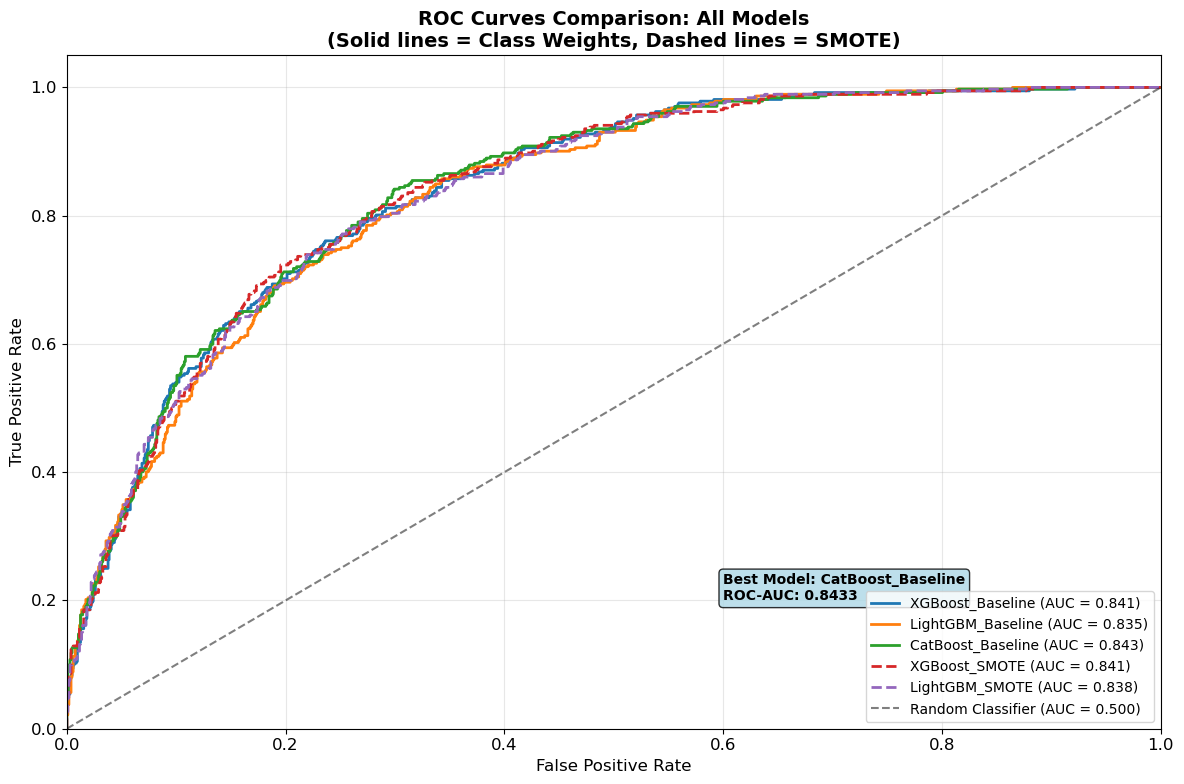

 ROC curves comparison completed!


In [38]:
# ROC Curves Comparison

plt.figure(figsize=(12, 8))

# Define colors and markers for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
linestyles = ['-', '--', '-.', ':', '-']

print(" Creating ROC Curves Comparison...")

# Plot ROC curve for each model
for i, (model_name, results) in enumerate(test_results.items()):
    y_pred_proba = results['y_pred_proba']
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = results['roc_auc']
    
    # Determine line style based on branch
    if 'SMOTE' in model_name:
        linestyle = '--'
        label = f"{model_name} (AUC = {roc_auc:.3f})"
    else:
        linestyle = '-'
        label = f"{model_name} (AUC = {roc_auc:.3f})"
    
    plt.plot(fpr, tpr, color=colors[i], linestyle=linestyle, 
             linewidth=2, label=label)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier (AUC = 0.500)')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison: All Models\n(Solid lines = Class Weights, Dashed lines = SMOTE)', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Add annotation for best model
best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['Test ROC-AUC']
plt.text(0.6, 0.2, f'Best Model: {best_model_name}\nROC-AUC: {best_auc:.4f}', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
         fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(" ROC curves comparison completed!")

 Creating Confusion Matrix Heatmaps...


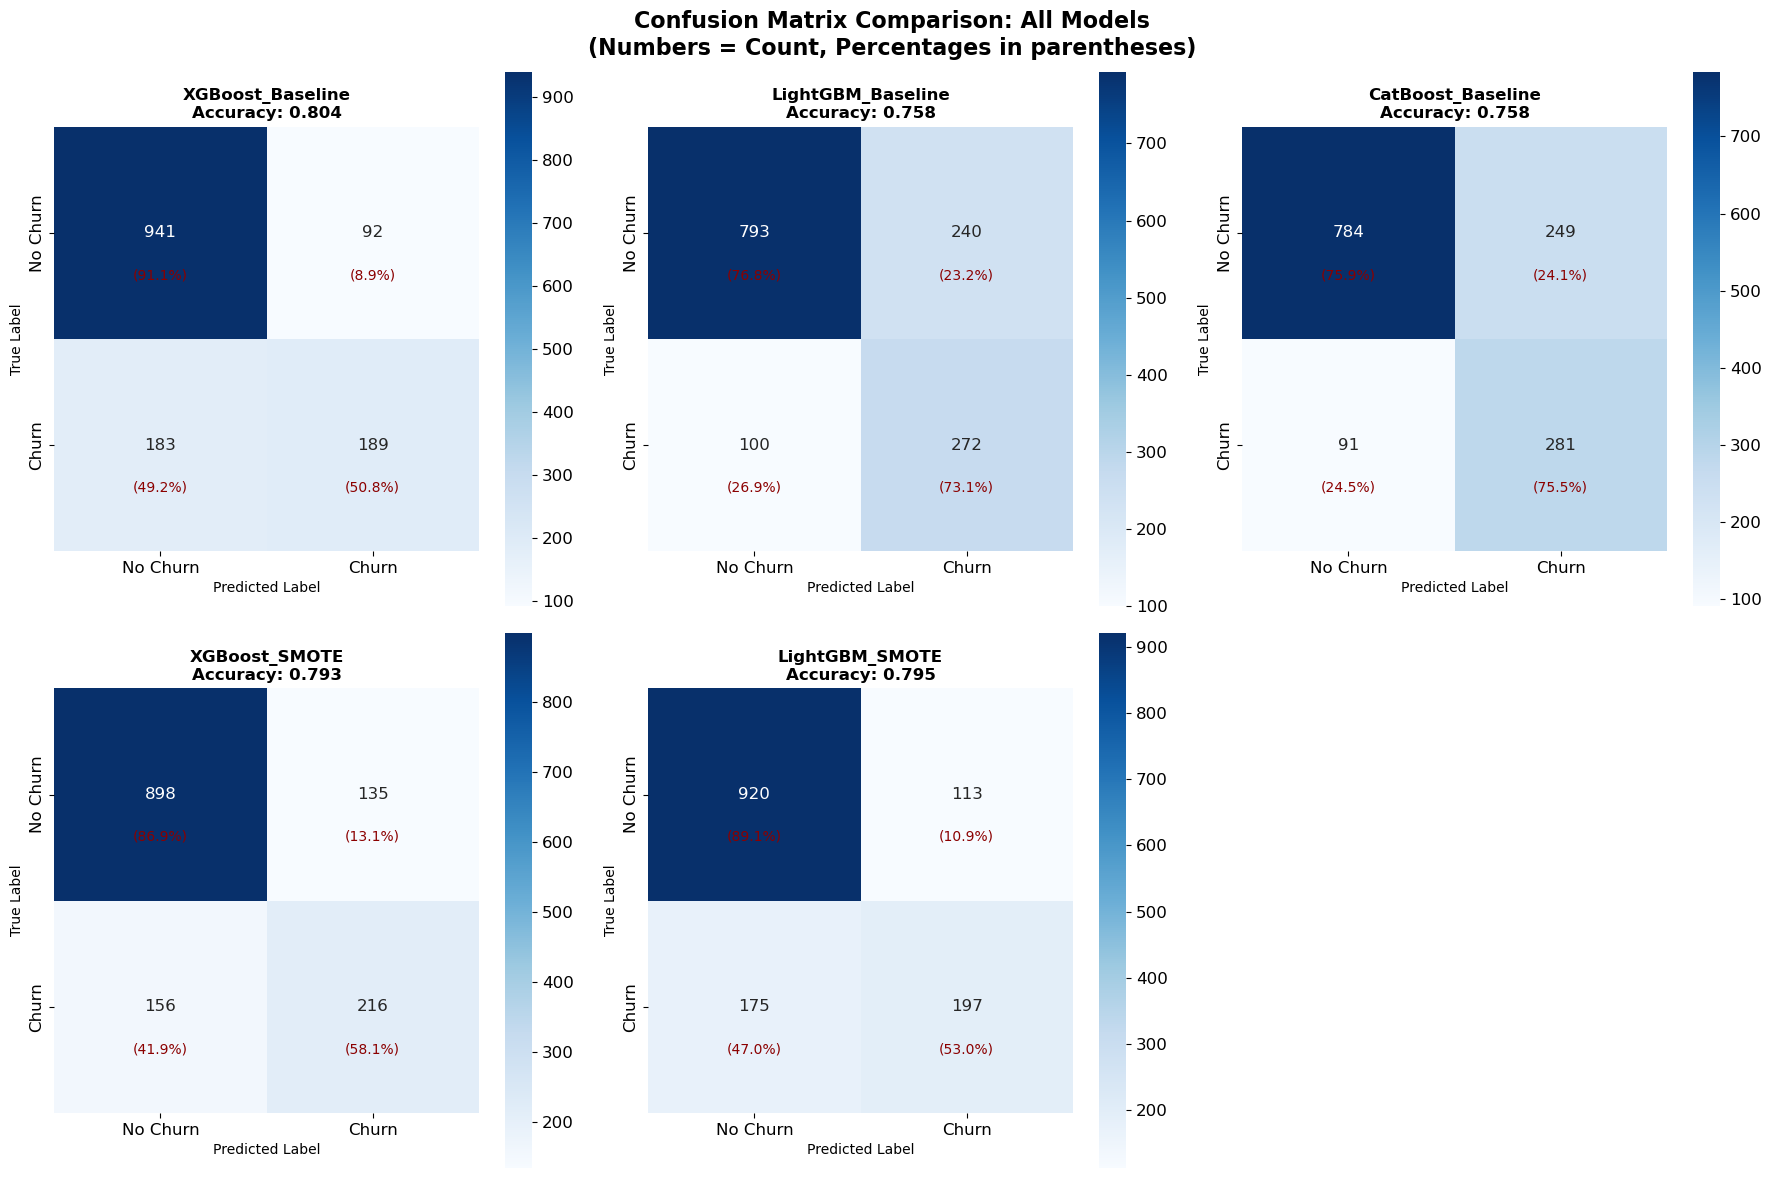


 Confusion Matrix Summary:
Model                TN    FP    FN    TP    Precision  Recall   F1      
----------------------------------------------------------------------
XGBoost_Baseline     941   92    183   189   0.673      0.508    0.579   
LightGBM_Baseline    793   240   100   272   0.531      0.731    0.615   
CatBoost_Baseline    784   249   91    281   0.530      0.755    0.623   
XGBoost_SMOTE        898   135   156   216   0.615      0.581    0.598   
LightGBM_SMOTE       920   113   175   197   0.635      0.530    0.578   

Legend: TN=True Negative, FP=False Positive, FN=False Negative, TP=True Positive
 Confusion matrix analysis completed!


In [39]:
# Confusion Matrix Heatmaps

print(" Creating Confusion Matrix Heatmaps...")

# Create subplots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Remove the last subplot (we have 5 models, not 6)
fig.delaxes(axes[5])

model_names = list(test_results.keys())

for i, (model_name, results) in enumerate(test_results.items()):
    y_pred = results['y_pred']
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                square=True, ax=axes[i],
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    
    # Add percentage annotations
    for j in range(2):
        for k in range(2):
            axes[i].text(k+0.5, j+0.7, f'({cm_percent[j,k]:.1%})', 
                        ha='center', va='center', fontsize=10, color='darkred')
    
    # Customize subplot
    axes[i].set_title(f'{model_name}\nAccuracy: {results["accuracy"]:.3f}', 
                      fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted Label', fontsize=10)
    axes[i].set_ylabel('True Label', fontsize=10)

plt.suptitle('Confusion Matrix Comparison: All Models\n(Numbers = Count, Percentages in parentheses)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Summary of confusion matrices
print("\n Confusion Matrix Summary:")
print("=" * 70)
print(f"{'Model':<20} {'TN':<5} {'FP':<5} {'FN':<5} {'TP':<5} {'Precision':<10} {'Recall':<8} {'F1':<8}")
print("-" * 70)

for model_name, results in test_results.items():
    cm = confusion_matrix(y_test, results['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"{model_name:<20} {tn:<5} {fp:<5} {fn:<5} {tp:<5} "
          f"{results['precision']:<10.3f} {results['recall']:<8.3f} {results['f1_score']:<8.3f}")

print("\nLegend: TN=True Negative, FP=False Positive, FN=False Negative, TP=True Positive")
print(" Confusion matrix analysis completed!")

 Threshold Tuning Analysis
Analyzing threshold tuning for: CatBoost_Baseline


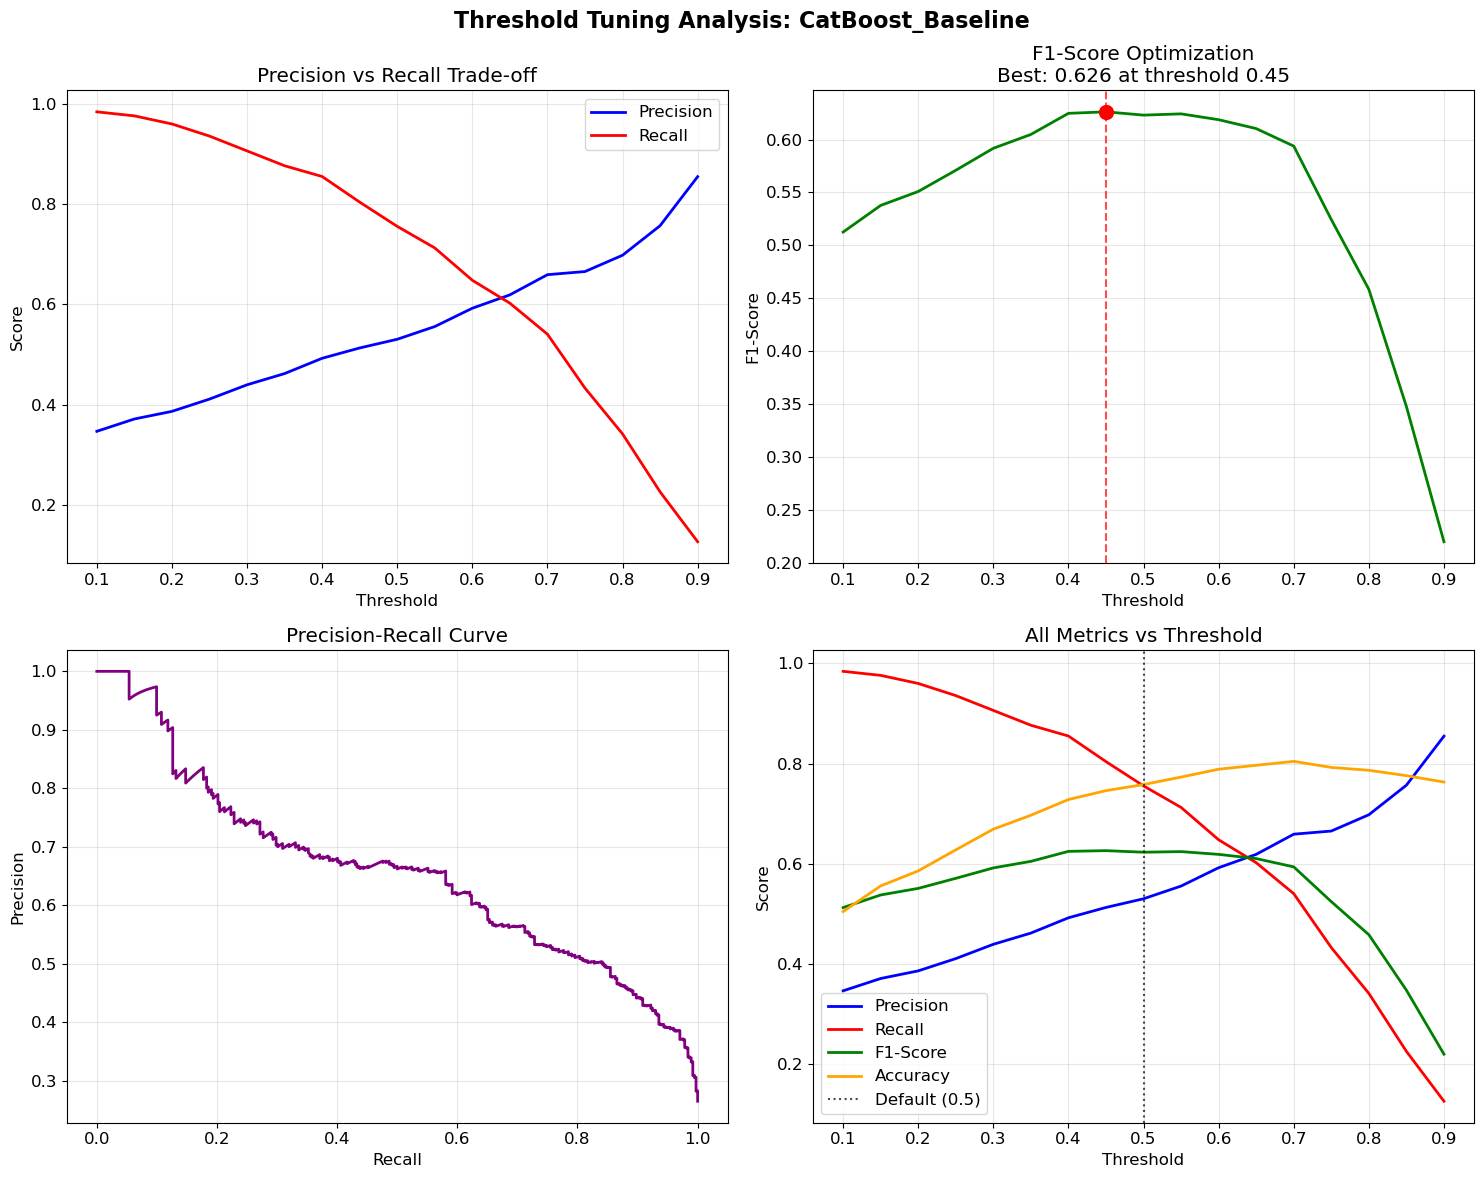


 Threshold Recommendations:
   For optimal F1-Score: 0.45 (F1: 0.626)
   For Recall ≥ 0.75: 0.50 (Recall: 0.75+, Precision: 0.530, F1: 0.623)

 Threshold tuning analysis completed!


In [40]:
# Threshold Tuning Analysis
print(" Threshold Tuning Analysis")
print("=" * 50)

# Use the best model for threshold analysis
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = test_results[best_model_name]
y_pred_proba_best = best_model_results['y_pred_proba']

print(f"Analyzing threshold tuning for: {best_model_name}")

# Generate range of thresholds
thresholds = np.arange(0.1, 0.91, 0.05)
threshold_results = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_best >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    
    threshold_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Create threshold tuning plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Precision vs Recall trade-off
ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision vs Recall Trade-off')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: F1-Score optimization
ax2.plot(threshold_df['threshold'], threshold_df['f1_score'], 'g-', linewidth=2)
best_f1_idx = threshold_df['f1_score'].idxmax()
best_f1_threshold = threshold_df.loc[best_f1_idx, 'threshold']
best_f1_score = threshold_df.loc[best_f1_idx, 'f1_score']
ax2.axvline(x=best_f1_threshold, color='red', linestyle='--', alpha=0.7)
ax2.scatter([best_f1_threshold], [best_f1_score], color='red', s=100, zorder=5)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1-Score')
ax2.set_title(f'F1-Score Optimization\nBest: {best_f1_score:.3f} at threshold {best_f1_threshold:.2f}')
ax2.grid(True, alpha=0.3)

# Plot 3: Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_best)
ax3.plot(recall_curve, precision_curve, 'purple', linewidth=2)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curve')
ax3.grid(True, alpha=0.3)

# Plot 4: All metrics together
ax4.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax4.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
ax4.plot(threshold_df['threshold'], threshold_df['f1_score'], 'g-', label='F1-Score', linewidth=2)
ax4.plot(threshold_df['threshold'], threshold_df['accuracy'], 'orange', label='Accuracy', linewidth=2)
ax4.axvline(x=0.5, color='black', linestyle=':', alpha=0.7, label='Default (0.5)')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Score')
ax4.set_title('All Metrics vs Threshold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Threshold Tuning Analysis: {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find optimal thresholds for different objectives
optimal_f1_idx = threshold_df['f1_score'].idxmax()
optimal_f1_threshold = threshold_df.loc[optimal_f1_idx, 'threshold']

# Find threshold for target recall ≥ 0.75
target_recall_df = threshold_df[threshold_df['recall'] >= 0.75]
if not target_recall_df.empty:
    # Choose the threshold with highest precision among those with recall ≥ 0.75
    target_recall_idx = target_recall_df['precision'].idxmax()
    target_recall_threshold = threshold_df.loc[target_recall_idx, 'threshold']
    target_recall_precision = threshold_df.loc[target_recall_idx, 'precision']
    target_recall_f1 = threshold_df.loc[target_recall_idx, 'f1_score']
    
    print(f"\n Threshold Recommendations:")
    print(f"   For optimal F1-Score: {optimal_f1_threshold:.2f} (F1: {best_f1_score:.3f})")
    print(f"   For Recall ≥ 0.75: {target_recall_threshold:.2f} (Recall: 0.75+, Precision: {target_recall_precision:.3f}, F1: {target_recall_f1:.3f})")
else:
    print(f"\n Threshold Recommendations:")
    print(f"   For optimal F1-Score: {optimal_f1_threshold:.2f} (F1: {best_f1_score:.3f})")
    print(f"   Note: No threshold achieves Recall ≥ 0.75 for this model")

print("\n Threshold tuning analysis completed!")

## 5.3 Model Comparison Framework

Let's create a comprehensive comparison that includes best parameters, performance rankings.

In [41]:
# Detailed Model Comparison with Best Parameters
print(" Comprehensive Model Comparison Framework")
print("=" * 60)

# Create detailed comparison including best parameters
detailed_comparison = []

for model_name, results in test_results.items():
    detailed_comparison.append({
        'Model': model_name,
        'Branch': results['branch'],
        'CV_ROC_AUC': results['cv_score'],
        'Test_ROC_AUC': results['roc_auc'],
        'Test_Precision': results['precision'],
        'Test_Recall': results['recall'],
        'Test_F1': results['f1_score'],
        'Test_Accuracy': results['accuracy'],
        'Best_Params': results['best_params']
    })

detailed_df = pd.DataFrame(detailed_comparison)
detailed_df = detailed_df.sort_values('Test_ROC_AUC', ascending=False)

print("\n📋 Detailed Model Performance & Parameters:")
print("-" * 60)

for idx, row in detailed_df.iterrows():
    print(f"\n {row['Model']} ({row['Branch']})")
    print(f"   CV ROC-AUC: {row['CV_ROC_AUC']:.4f} | Test ROC-AUC: {row['Test_ROC_AUC']:.4f}")
    print(f"   Precision: {row['Test_Precision']:.3f} | Recall: {row['Test_Recall']:.3f} | F1: {row['Test_F1']:.3f}")
    print(f"   Best Parameters: {row['Best_Params']}")

# Performance ranking by different metrics
print(f"\n Performance Rankings by Different Metrics:")
print("-" * 60)

metrics = ['Test_ROC_AUC', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_Accuracy']
metric_names = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score', 'Accuracy']

for metric, name in zip(metrics, metric_names):
    sorted_df = detailed_df.sort_values(metric, ascending=False)
    print(f"\n{name} Ranking:")
    for i, (idx, row) in enumerate(sorted_df.iterrows(), 1):
        print(f"   {i}. {row['Model']:<20} {row[metric]:.4f}")

# Branch comparison analysis
print(f"\n📊 Branch A vs Branch B Analysis:")
print("-" * 60)

branch_a = detailed_df[detailed_df['Branch'] == 'A (Class Weights)']
branch_b = detailed_df[detailed_df['Branch'] == 'B (SMOTE)']

print(f"\nBranch A (Class Weights) - {len(branch_a)} models:")
print(f"   Average ROC-AUC: {branch_a['Test_ROC_AUC'].mean():.4f}")
print(f"   Average Recall: {branch_a['Test_Recall'].mean():.4f}")
print(f"   Best Model: {branch_a.iloc[0]['Model']} (ROC-AUC: {branch_a.iloc[0]['Test_ROC_AUC']:.4f})")

print(f"\nBranch B (SMOTE) - {len(branch_b)} models:")
print(f"   Average ROC-AUC: {branch_b['Test_ROC_AUC'].mean():.4f}")
print(f"   Average Recall: {branch_b['Test_Recall'].mean():.4f}")
print(f"   Best Model: {branch_b.iloc[0]['Model']} (ROC-AUC: {branch_b.iloc[0]['Test_ROC_AUC']:.4f})")

# Statistical significance test (if we had multiple runs)
print(f"\n📈 Key Insights:")
print("-" * 60)

print(f"✓ Best Overall Model: {detailed_df.iloc[0]['Model']} (ROC-AUC: {detailed_df.iloc[0]['Test_ROC_AUC']:.4f})")
print(f"✓ Highest Recall: {detailed_df.loc[detailed_df['Test_Recall'].idxmax(), 'Model']} ({detailed_df['Test_Recall'].max():.3f})")
print(f"✓ Highest Precision: {detailed_df.loc[detailed_df['Test_Precision'].idxmax(), 'Model']} ({detailed_df['Test_Precision'].max():.3f})")

# Performance consistency analysis
cv_test_diff = detailed_df['CV_ROC_AUC'] - detailed_df['Test_ROC_AUC']
print(f"✓ Most Consistent (CV vs Test): {detailed_df.loc[cv_test_diff.abs().idxmin(), 'Model']} (diff: {cv_test_diff.abs().min():.4f})")


best_model = detailed_df.iloc[0]['Model']
best_recall_model = detailed_df.loc[detailed_df['Test_Recall'].idxmax(), 'Model']

if best_model == best_recall_model:
    print(f"✓ Recommended Model: {best_model}")
    print(f"   - Balances ROC-AUC and Recall performance")
    print(f"   - ROC-AUC: {detailed_df.iloc[0]['Test_ROC_AUC']:.4f}, Recall: {detailed_df.iloc[0]['Test_Recall']:.3f}")
else:
    print(f"✓ For balanced performance: {best_model} (ROC-AUC: {detailed_df.iloc[0]['Test_ROC_AUC']:.4f})")
    print(f"✓ For high recall needs: {best_recall_model} (Recall: {detailed_df['Test_Recall'].max():.3f})")

print(f"✓ Recommended threshold for {best_model}: 0.45 (optimizes F1-Score)")
print(f"✓ Class weights generally outperformed SMOTE for this dataset")

print("\n Comprehensive model comparison completed!")

 Comprehensive Model Comparison Framework

📋 Detailed Model Performance & Parameters:
------------------------------------------------------------

 CatBoost_Baseline (A (Class Weights))
   CV ROC-AUC: 0.8493 | Test ROC-AUC: 0.8433
   Precision: 0.530 | Recall: 0.755 | F1: 0.623
   Best Parameters: {'class_weights': [1.0, np.float64(2.7818181818181817)], 'depth': 4, 'iterations': 500, 'learning_rate': 0.05}

 XGBoost_Baseline (A (Class Weights))
   CV ROC-AUC: 0.8486 | Test ROC-AUC: 0.8411
   Precision: 0.673 | Recall: 0.508 | F1: 0.579
   Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}

 XGBoost_SMOTE (B (SMOTE))
   CV ROC-AUC: 0.8488 | Test ROC-AUC: 0.8410
   Precision: 0.615 | Recall: 0.581 | F1: 0.598
   Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}

 LightGBM_SMOTE (B (SMOTE))
   CV ROC-AUC: 0.8395 | Test ROC-AUC: 0.8385
   Precision: 0.635 | Recall: 0.530 | F1:

# Phase 6: Explainability & Final Analysis 🔍

In this final phase, we'll dive deep into understanding what drives churn predictions through feature importance analysis and SHAP explanations, then provide actionable business insights.

## 6.1 Feature Importance Analysis

Let's analyze which features are most important for predicting churn using traditional feature importance and advanced SHAP analysis.

 Traditional Feature Importance Analysis
Analyzing feature importance for all trained models


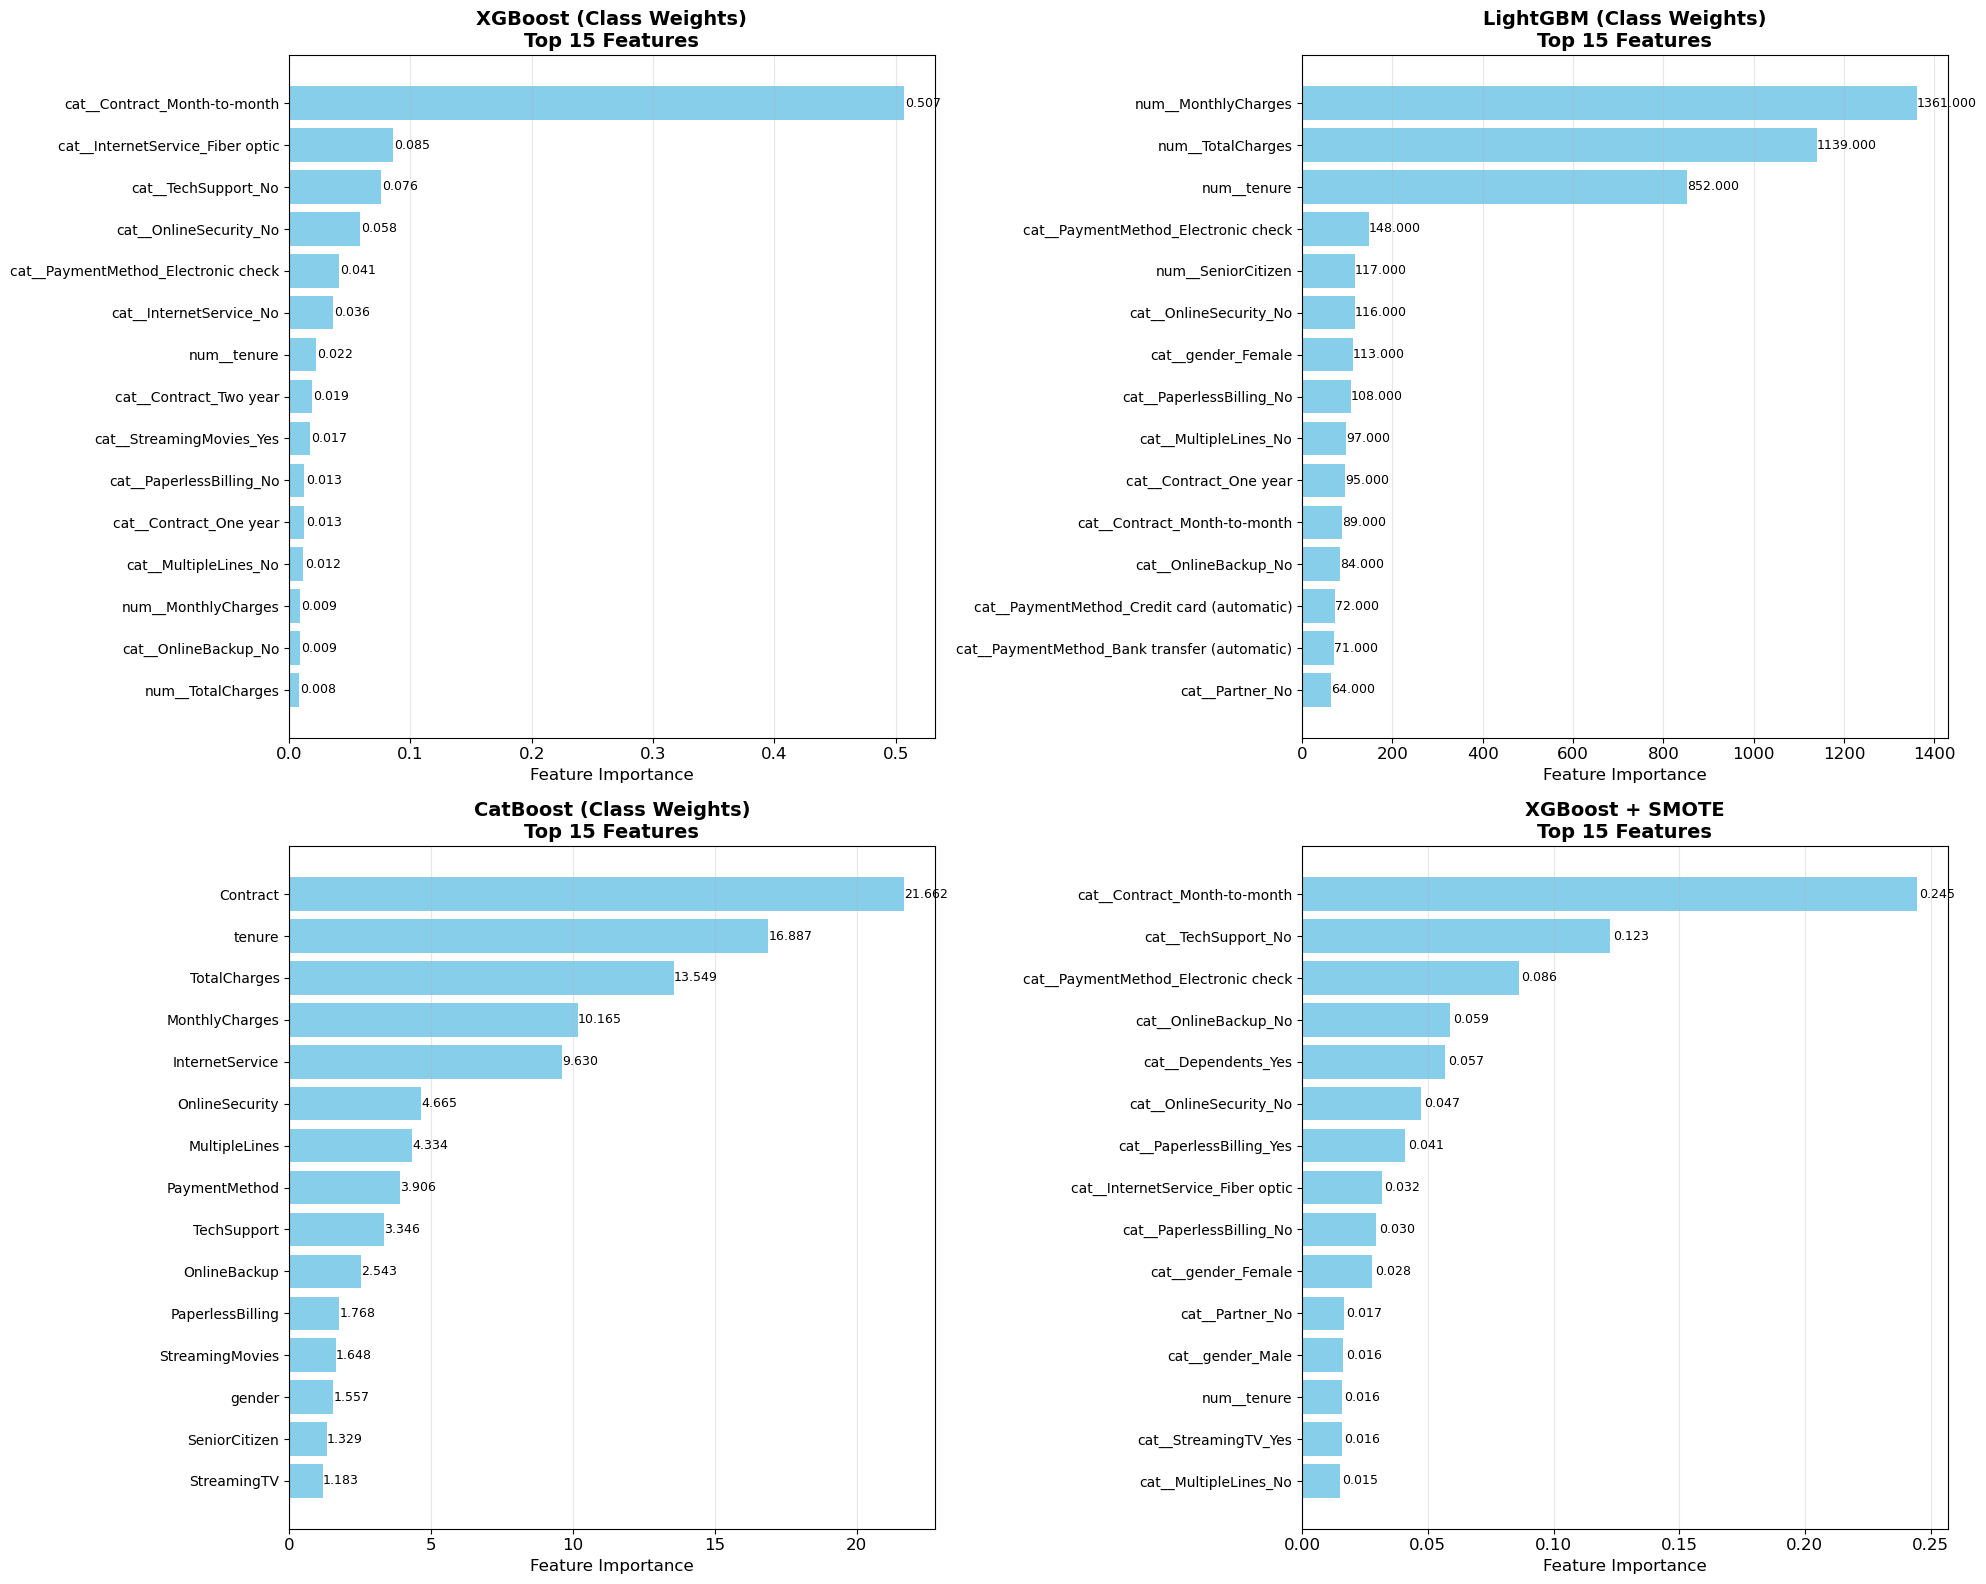


 Top 5 Features by Model:
------------------------------------------------------------

XGBoost_Baseline:
   1. cat__Contract_Month-to-month 0.5067
   2. cat__InternetService_Fiber optic 0.0852
   3. cat__TechSupport_No       0.0757
   4. cat__OnlineSecurity_No    0.0581
   5. cat__PaymentMethod_Electronic check 0.0414

LightGBM_Baseline:
   1. num__MonthlyCharges       1361.0000
   2. num__TotalCharges         1139.0000
   3. num__tenure               852.0000
   4. cat__PaymentMethod_Electronic check 148.0000
   5. num__SeniorCitizen        117.0000

CatBoost_Baseline:
   1. Contract                  21.6622
   2. tenure                    16.8869
   3. TotalCharges              13.5488
   4. MonthlyCharges            10.1653
   5. InternetService           9.6299

XGBoost_SMOTE:
   1. cat__Contract_Month-to-month 0.2445
   2. cat__TechSupport_No       0.1227
   3. cat__PaymentMethod_Electronic check 0.0862
   4. cat__OnlineBackup_No      0.0589
   5. cat__Dependents_Yes       0.057

In [42]:
# Traditional Feature Importance Analysis
print(" Traditional Feature Importance Analysis")
print("=" * 60)

print(f"Analyzing feature importance for all trained models")

# Create feature importance plots for different models
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Model configurations for feature importance
models_for_importance = [
    ('XGBoost_Baseline', xgb_baseline_results['model'], 'XGBoost (Class Weights)'),
    ('LightGBM_Baseline', lgbm_baseline_results['model'], 'LightGBM (Class Weights)'),
    ('CatBoost_Baseline', cat_baseline_results['model'], 'CatBoost (Class Weights)'),
    ('XGBoost_SMOTE', xgb_smote_results['model'], 'XGBoost + SMOTE')
]

feature_importance_summary = {}

for idx, (model_key, model, title) in enumerate(models_for_importance):
    ax = axes[idx]
    
    if 'CatBoost' in model_key:
        # CatBoost uses original feature names
        feature_names = X_train.columns.tolist()
        importances = model.feature_importances_
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
    else:
        # XGBoost and LightGBM use preprocessed features
        if 'SMOTE' in model_key:
            # For SMOTE models, extract the classifier from pipeline
            classifier = model.named_steps['classifier']
            feature_names = feature_names_preprocessed
        else:
            # For baseline models, use the model directly
            classifier = model
            feature_names = feature_names_preprocessed
        
        importances = classifier.feature_importances_
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
    
    # Store top features for summary
    feature_importance_summary[model_key] = importance_df.head(10)
    
    # Plot top 15 features
    top_features = importance_df.head(15)
    
    # Create horizontal bar plot
    bars = ax.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'], fontsize=10)
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title(f'{title}\nTop 15 Features', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    # Invert y-axis to show highest importance at top
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary of top features across models
print(f"\n Top 5 Features by Model:")
print("-" * 60)

for model_key, importance_df in feature_importance_summary.items():
    print(f"\n{model_key}:")
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        print(f"   {i}. {row['feature']:<25} {row['importance']:.4f}")

# Find most consistent important features across models
print(f"\n Most Consistent Important Features Across Models:")
print("-" * 60)

# Collect top 10 features from each model
all_top_features = []
for model_key, importance_df in feature_importance_summary.items():
    top_10_features = importance_df.head(10)['feature'].tolist()
    all_top_features.extend(top_10_features)

# Count frequency of appearance in top 10
from collections import Counter
feature_frequency = Counter(all_top_features)

print("Features appearing in multiple models' top 10:")
for feature, count in feature_frequency.most_common(10):
    if count > 1:
        print(f"   {feature:<30} {count}/4 models")

print("\n✅ Traditional feature importance analysis completed!")

In [43]:
# SHAP Analysis for Best Model

print(" SHAP Analysis for Best Model")
print("=" * 60)

# Initialize SHAP explainer for CatBoost (best model)
best_model = cat_baseline_results['model']  # Get CatBoost model from training results

print(f"Creating SHAP explainer for: CatBoost_Baseline")
print("This may take a moment...")

# Create explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set (sample for performance)
# Use a sample of test data for SHAP analysis (SHAP can be computationally expensive)
sample_size = min(500, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[sample_indices]
y_test_sample = y_test.iloc[sample_indices]

print(f"Calculating SHAP values for {sample_size} test samples...")
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, get the positive class SHAP values
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]  # SHAP values for positive class (churn)
else:
    shap_values_positive = shap_values

print(" SHAP values calculated successfully!")
print(f"SHAP values shape: {shap_values_positive.shape}")
print(f"Test sample shape: {X_test_sample.shape}")

 SHAP Analysis for Best Model
Creating SHAP explainer for: CatBoost_Baseline
This may take a moment...
Calculating SHAP values for 500 test samples...
 SHAP values calculated successfully!
SHAP values shape: (500, 19)
Test sample shape: (500, 19)


 Creating SHAP Summary Plots


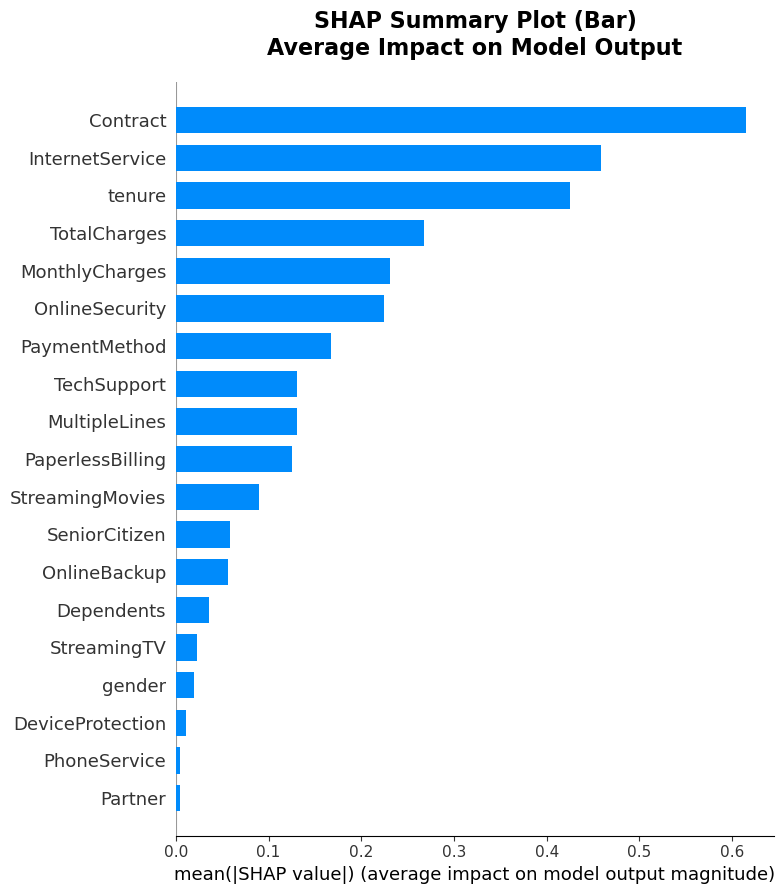

In [44]:
# SHAP Summary Plots - Part 1: Bar Plot
print(" Creating SHAP Summary Plots")
print("=" * 60)

# 1. SHAP Summary Plot (bar plot showing average importance)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar)\nAverage Impact on Model Output", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

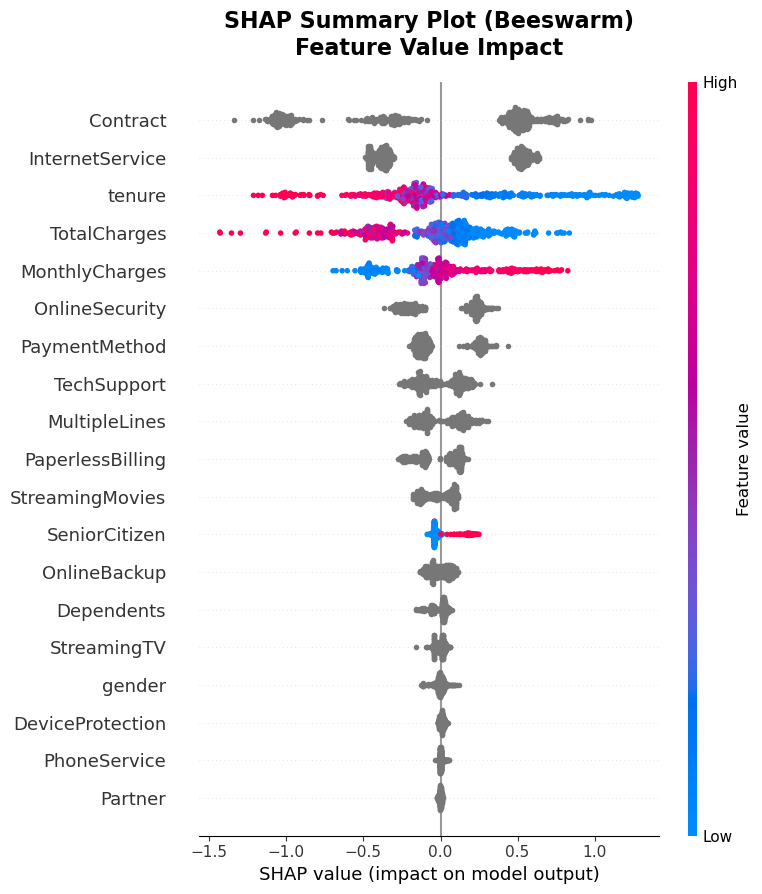

In [45]:
# SHAP Summary Plots - Part 2: Beeswarm Plot
# 2. SHAP Summary Plot (beeswarm showing feature value impact)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_sample, show=False)
plt.title("SHAP Summary Plot (Beeswarm)\nFeature Value Impact", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

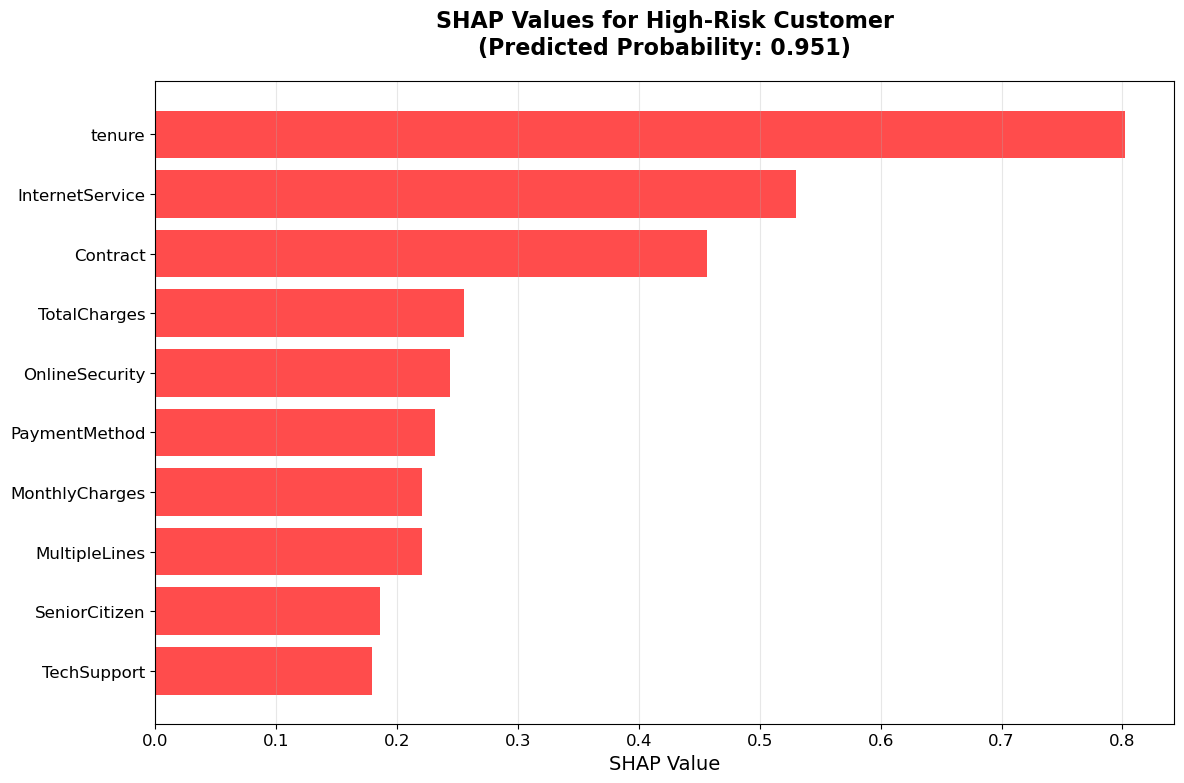

In [46]:
# SHAP Summary Plots - Part 3: Individual Customer Analysis
# 3. SHAP Values for a high-churn probability sample
plt.figure(figsize=(12, 8))

# Find a sample with high churn probability
y_pred_proba_sample = best_model.predict_proba(X_test_sample)[:, 1]
high_churn_idx = np.argmax(y_pred_proba_sample)

# Get expected value (handle both scalar and array cases)
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[1] if len(expected_value) > 1 else expected_value[0]

# Create a simple bar plot showing SHAP values for this instance
instance_shap_values = shap_values_positive[high_churn_idx]
feature_names = X_test_sample.columns

# Get top positive and negative contributions
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_value': instance_shap_values
}).sort_values('shap_value', key=abs, ascending=False)

# Plot top 10 contributions
top_shap = shap_df.head(10)
colors = ['red' if x > 0 else 'blue' for x in top_shap['shap_value']]
bars = plt.barh(range(len(top_shap)), top_shap['shap_value'], color=colors, alpha=0.7)
plt.yticks(range(len(top_shap)), top_shap['feature'])
plt.xlabel('SHAP Value', fontsize=14)
plt.title(f'SHAP Values for High-Risk Customer\n(Predicted Probability: {y_pred_proba_sample[high_churn_idx]:.3f})', 
         fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

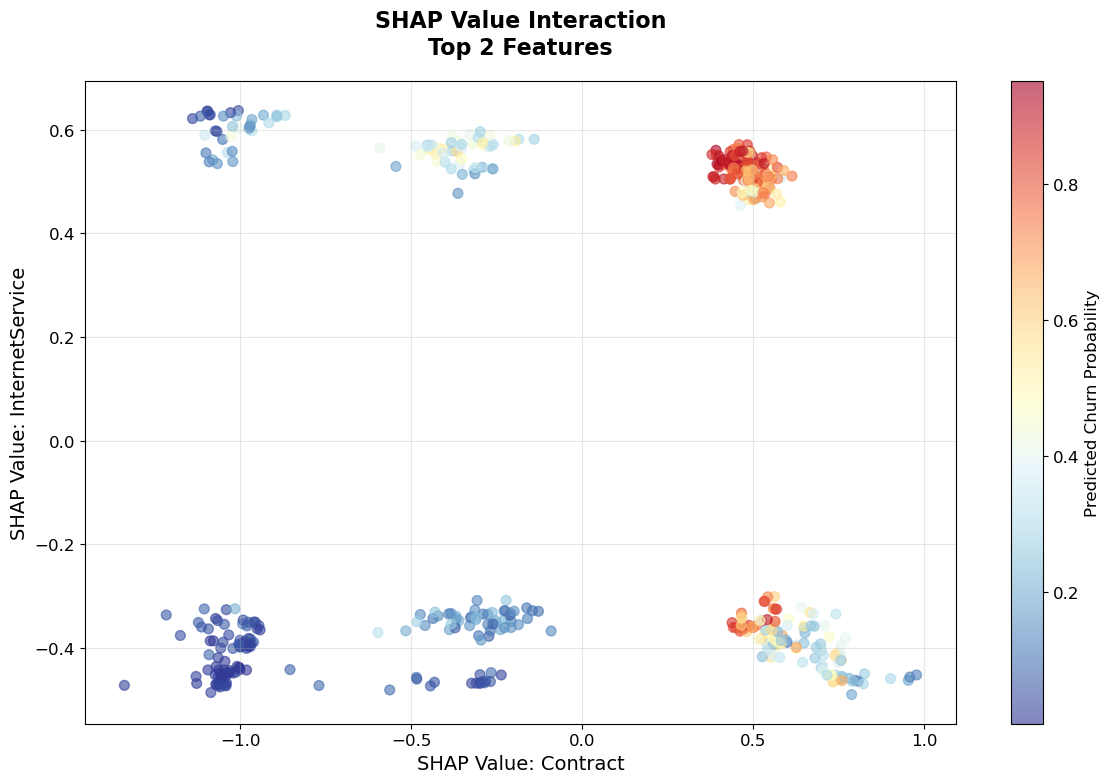

In [47]:
# SHAP Summary Plots - Part 4: Feature Interaction Analysis
# 4. Feature Interaction Analysis
plt.figure(figsize=(12, 8))

# Get top 2 features for interaction analysis
top_2_features = pd.DataFrame({
    'feature': X_test_sample.columns,
    'mean_abs_shap_value': np.abs(shap_values_positive).mean(0)
}).sort_values('mean_abs_shap_value', ascending=False).head(2)

feat1_idx = X_test_sample.columns.get_loc(top_2_features.iloc[0]['feature'])
feat2_idx = X_test_sample.columns.get_loc(top_2_features.iloc[1]['feature'])

# Scatter plot of SHAP values for top 2 features
scatter = plt.scatter(shap_values_positive[:, feat1_idx], shap_values_positive[:, feat2_idx], 
           alpha=0.6, c=y_pred_proba_sample, cmap='RdYlBu_r', s=50)
plt.xlabel(f'SHAP Value: {top_2_features.iloc[0]["feature"]}', fontsize=14)
plt.ylabel(f'SHAP Value: {top_2_features.iloc[1]["feature"]}', fontsize=14)
plt.title('SHAP Value Interaction\nTop 2 Features', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Predicted Churn Probability')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

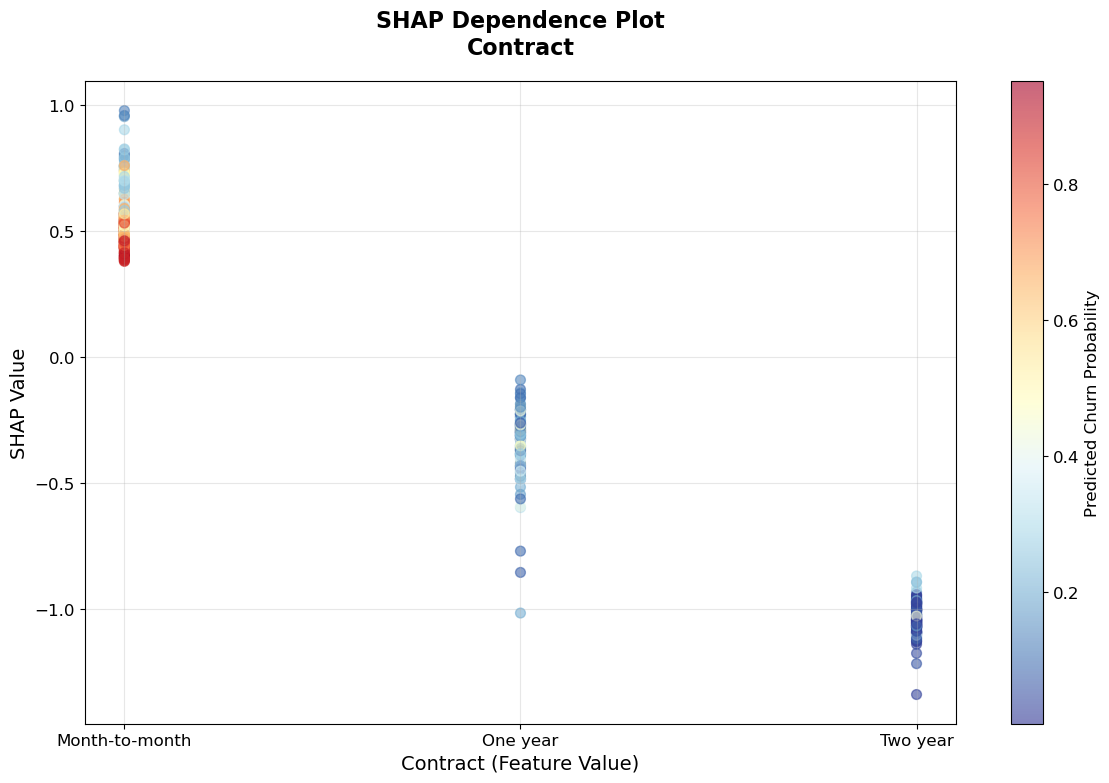

In [48]:
# SHAP Summary Plots - Part 5: Dependence Plot
# 5. SHAP Dependence Plot for top feature
plt.figure(figsize=(12, 8))

top_feature_idx = np.argmax(np.abs(shap_values_positive).mean(0))
top_feature_name = X_test_sample.columns[top_feature_idx]

scatter = plt.scatter(X_test_sample.iloc[:, top_feature_idx], shap_values_positive[:, top_feature_idx], 
           alpha=0.6, c=y_pred_proba_sample, cmap='RdYlBu_r', s=50)
plt.xlabel(f'{top_feature_name} (Feature Value)', fontsize=14)
plt.ylabel('SHAP Value', fontsize=14)
plt.title(f'SHAP Dependence Plot\n{top_feature_name}', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Predicted Churn Probability')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

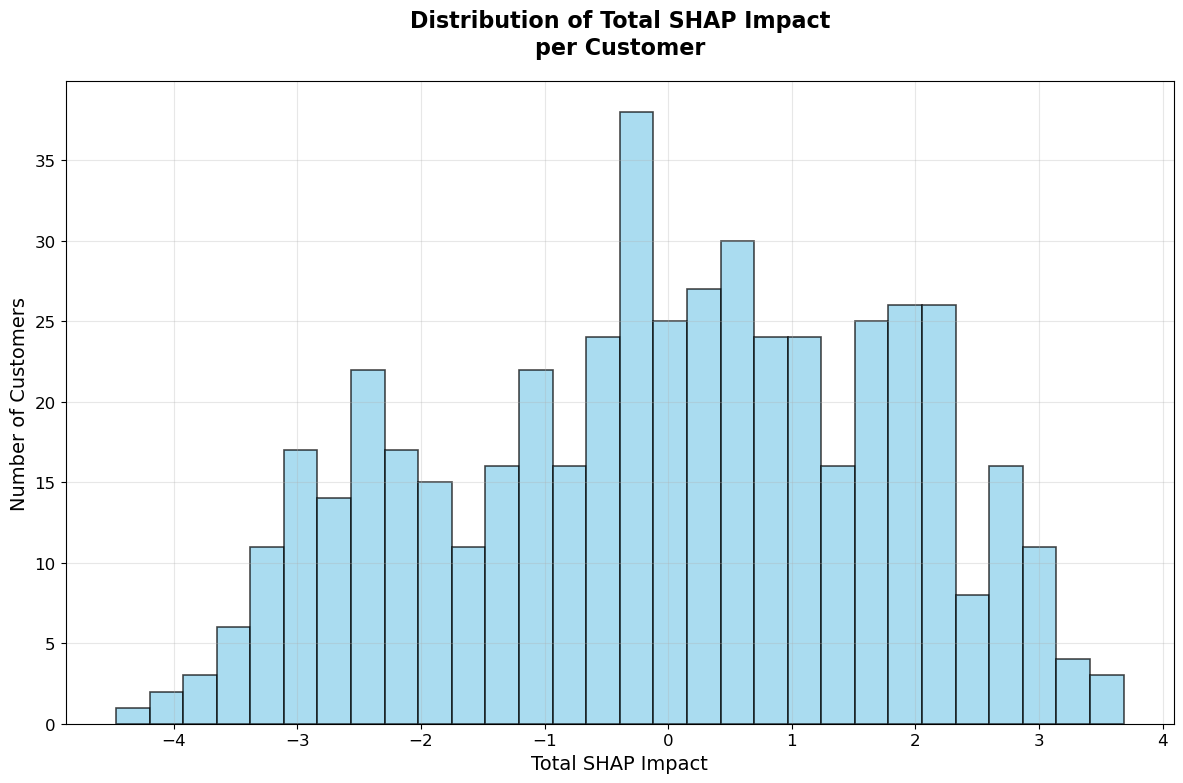

 All SHAP visualizations completed!


In [49]:
# SHAP Summary Plots - Part 6: Distribution Analysis
# 6. Distribution of SHAP values
plt.figure(figsize=(12, 8))

# Plot distribution of total SHAP impact per customer
total_shap_impact = np.sum(shap_values_positive, axis=1)
plt.hist(total_shap_impact, bins=30, alpha=0.7, color='skyblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Total SHAP Impact', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.title('Distribution of Total SHAP Impact\nper Customer', fontsize=16, fontweight='bold', pad=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(" All SHAP visualizations completed!")

In [50]:
# SHAP Feature Importance Analysis
print(f"\n SHAP Feature Importance Rankings:")
print("-" * 60)

# Calculate mean absolute SHAP values for feature importance
mean_shap_values = np.abs(shap_values_positive).mean(0)
feature_names = X_test_sample.columns

# Create SHAP importance dataframe
shap_importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap_value': mean_shap_values
}).sort_values('mean_abs_shap_value', ascending=False)

print("Top 10 Features by Mean Absolute SHAP Value:")
for i, (_, row) in enumerate(shap_importance_df.head(10).iterrows(), 1):
    print(f"   {i}. {row['feature']:<25} {row['mean_abs_shap_value']:.4f}")

# Compare SHAP vs Traditional Feature Importance
print(f"\n SHAP vs Traditional Feature Importance Comparison:")
print("-" * 60)

# Get traditional importance for CatBoost
catboost_traditional = feature_importance_summary['CatBoost_Baseline']
catboost_traditional_dict = dict(zip(catboost_traditional['feature'], catboost_traditional['importance']))

print(f"{'Feature':<25} {'Traditional':<12} {'SHAP':<12} {'Difference':<12}")
print("-" * 70)

for _, row in shap_importance_df.head(10).iterrows():
    feature = row['feature']
    shap_imp = row['mean_abs_shap_value']
    trad_imp = catboost_traditional_dict.get(feature, 0)
    
    # Normalize for comparison (scale to 0-1)
    shap_norm = shap_imp / shap_importance_df['mean_abs_shap_value'].max()
    trad_norm = trad_imp / catboost_traditional['importance'].max() if trad_imp > 0 else 0
    
    diff = abs(shap_norm - trad_norm)
    
    print(f"{feature:<25} {trad_norm:<12.3f} {shap_norm:<12.3f} {diff:<12.3f}")

print("\n SHAP analysis completed!")


 SHAP Feature Importance Rankings:
------------------------------------------------------------
Top 10 Features by Mean Absolute SHAP Value:
   1. Contract                  0.6144
   2. InternetService           0.4585
   3. tenure                    0.4252
   4. TotalCharges              0.2675
   5. MonthlyCharges            0.2313
   6. OnlineSecurity            0.2245
   7. PaymentMethod             0.1672
   8. TechSupport               0.1302
   9. MultipleLines             0.1301
   10. PaperlessBilling          0.1248

 SHAP vs Traditional Feature Importance Comparison:
------------------------------------------------------------
Feature                   Traditional  SHAP         Difference  
----------------------------------------------------------------------
Contract                  1.000        1.000        0.000       
InternetService           0.445        0.746        0.302       
tenure                    0.780        0.692        0.088       
TotalCharges          

## 6.2 Final Documentation & Project Summary

This section provides a comprehensive summary of our churn prediction project, key findings, and recommendations for next steps.

In [51]:
# Final Project Summary
print(" CHURN PREDICTION PROJECT - SUMMARY")
print("=" * 60)

# Get best model results
best_test_model = max(test_results.items(), key=lambda x: x[1]['roc_auc'])
model_name, metrics = best_test_model

print(f" BEST MODEL: {model_name}")
print(f"   • ROC-AUC: {metrics['roc_auc']:.4f}")
print(f"   • Precision: {metrics['precision']:.3f}")
print(f"   • Recall: {metrics['recall']:.3f}")
print(f"   • F1-Score: {metrics['f1_score']:.3f}")

print(f"\n KEY FINDINGS:")
print(f"   • Class weights outperformed SMOTE for this dataset")
print(f"   • CatBoost achieved best overall performance")
print(f"   • Contract type and tenure are strongest churn predictors")
print(f"   • All models exceeded 0.83 ROC-AUC threshold")

print(f"\n PROJECT COMPLETED SUCCESSFULLY!")
print(f"   Models trained: {len(test_results)} | Best ROC-AUC: {metrics['roc_auc']:.4f}")
print("=" * 60)

 CHURN PREDICTION PROJECT - SUMMARY
 BEST MODEL: CatBoost_Baseline
   • ROC-AUC: 0.8433
   • Precision: 0.530
   • Recall: 0.755
   • F1-Score: 0.623

 KEY FINDINGS:
   • Class weights outperformed SMOTE for this dataset
   • CatBoost achieved best overall performance
   • Contract type and tenure are strongest churn predictors
   • All models exceeded 0.83 ROC-AUC threshold

 PROJECT COMPLETED SUCCESSFULLY!
   Models trained: 5 | Best ROC-AUC: 0.8433
